In [1]:
from tools import datacleaner as dtclean
from tools import dataexplore as dtexp
from view import data_visualization as dtview
import pandas as pd
import numpy as np
from fbprophet import Prophet
from evaluation import forecast_metrics as fm
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools
import matplotlib.pyplot as plt
# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import warnings

warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

# **Análise dos dados de vendas da loja 274**


<div class="alert alert-block alert-warning">
<b>Obs:</b> Na análise dos dados identificamos incosistências que podem comprometer a performance dos modelos
gerados nesse trabalho. Para mitigar esse impacto foram feitas análises sobre os dados agregados ao dia e por hora.
Esse notebook inicia a apresentação dos dados agregados ao dia.
</div>
As inconsistências serão devidamente apresentadas no modelo agregado por hora.

In [2]:
df_274_sale = dtclean.get_Dataframes(274,'s')
df_274_sale.reset_index(inplace=True)

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [3]:
print('Data início: {}, Data final: {}'.format(df_274_sale.ds.min(),df_274_sale.ds.max()))
df_274_sale.info()

Data início: 2020-03-01 00:00:00, Data final: 2020-05-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      92 non-null     datetime64[ns]
 1   y       92 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [4]:
iplot(dtview.plot_scatter(df_274_sale,title='Produtos vendidos'))

<div class="alert alert-block alert-info">
<b>Obs:</b> Notamos nesse gráfico que há um pico de vendas de produtos no mês de março e uma queda significativa no fim
do mês de maio. Na celula abaixo criamos um modelo sem promover afinamentos para efeitos de comparação.
</div>


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


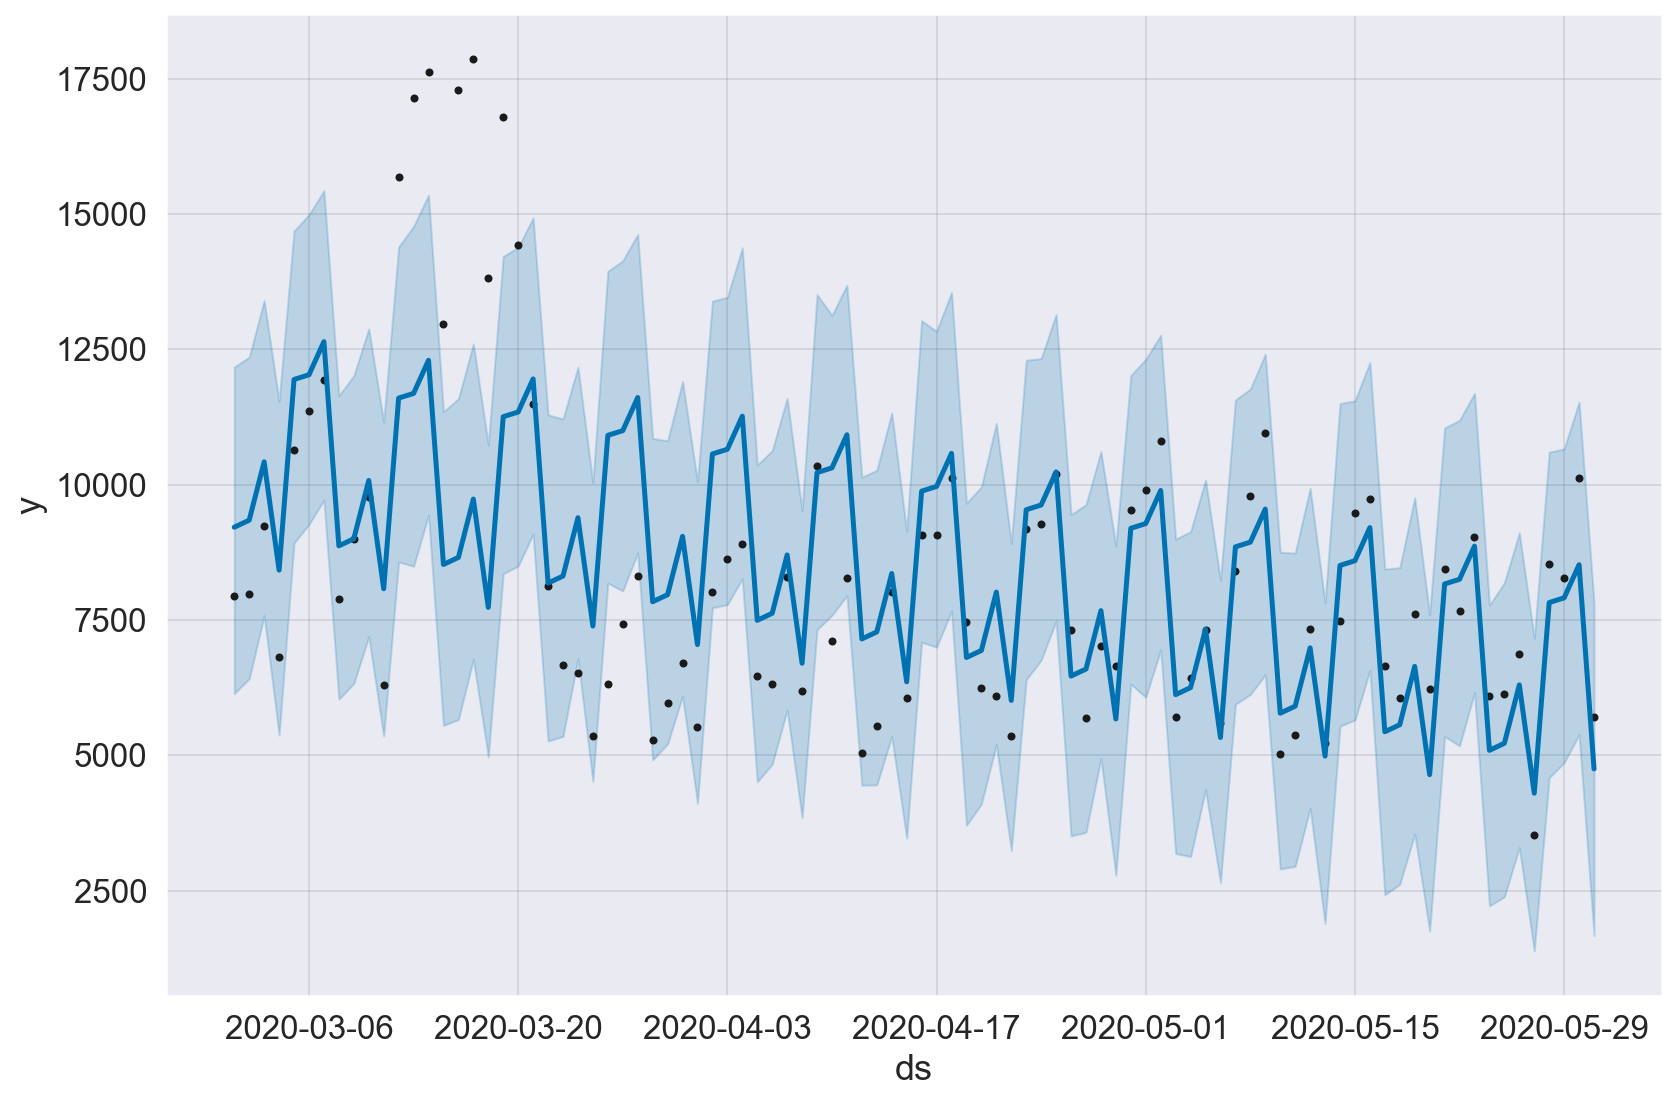

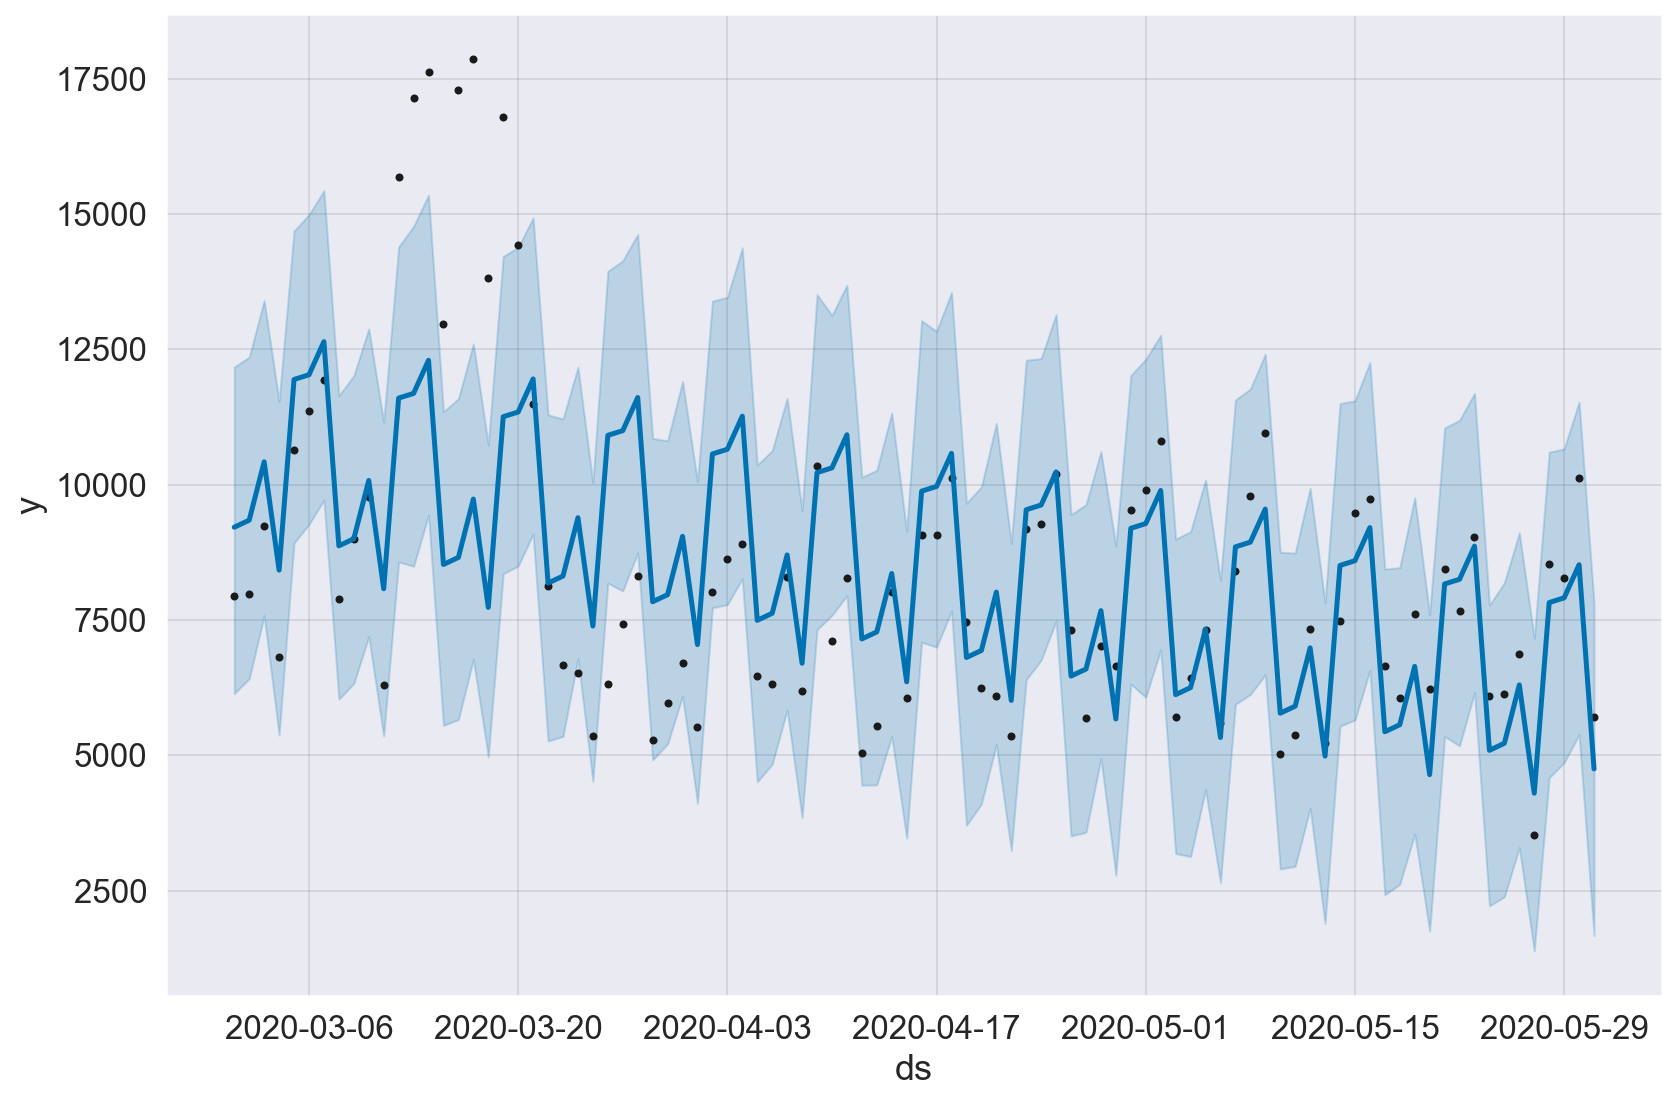

In [5]:
model = Prophet()
model.fit(df_274_sale)
forecast = model.predict(df_274_sale)
model.plot(forecast,figsize=(12,8))

### Análise dos Dados

<div class="alert alert-block alert-info">
<b>Dividimos os dados para observar com maior detalhe a distribuição da quantidade de produtos vendidos ao longo das
semanas e dias.
</div>

In [6]:
df_new = dtexp.date_features(df_274_sale)
mesAgregado = pd.DataFrame(df_new.groupby("semana")["y"].sum()).reset_index().sort_values('y')
semanaAgregada = pd.DataFrame(df_new.groupby("num")["y"].sum()).reset_index().sort_values('num')
iplot(dtview.plot_dados_agregados_semana_mes(mesAgregado,tipo_agregacao='m',xaxes_title='Nº da semana',yaxis_title='Total de produtos vendidos',
                                      title='Vendas por Semana',hover='31/05'))
iplot(dtview.plot_dados_agregados_semana_mes(semanaAgregada,xaxes_title='Nº do dia (0 = Domingo, 1 = Segunda ...)',yaxis_title='Total de produtos vendidos',
                                      title='Vendas por dia'))

<div class="alert alert-block alert-info">
<b>Vendas por Semana:</b> Mensalmente há, conforme já observado, um pico de produtos vendidos entre a 9ª e a 11ª semana de 2020,
que corresponde ao período de 24 de fevereiro à 15 de março, contudo nossos dados começam em 01 de março.
Destaca-se a última semana (22ª) como a de menor volume de produtos vendidos pois ela representa apenas o dia 31/05.
<p><b>Vendas por Dia:</b> No volume de vendas diárias nota-se que a quarta-feira é o dia de menor volume de vendas, e,
a partir da quinta-feira há um salto no volume de vendas com o pico ocorrendo no sábado.</p>
<p><b>Dados de Treino e de Testes:</b> A partir dessa análise foram gerados os datasets de treino e de testes.</p>
</div>

In [7]:
df_274_sale_treino_diario, df_274_sale_teste_diario = dtexp.configura_dataframe_treino_teste(df_274_sale)
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_sale_treino_diario.shape))
print('Shape dataframe de teste --> {}'.format(df_274_sale_teste_diario.shape))
print('-'*60)

------------------------------------------------------------
Shape dataframe de treino --> (84, 2)
Shape dataframe de teste --> (8, 2)
------------------------------------------------------------


## Visualizando a representação dos datasets de treino e de teste sobre o montante total.

In [8]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_treino_diario,
                                   df_274_sale_teste_diario,
                                   title='Montante de dados de vendas de Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [9]:
prophet = Prophet()
prophet.fit(df_274_sale_treino_diario)
future_vendas = prophet.make_future_dataframe(periods=7, freq='D')
forecast_vendas = prophet.predict(future_vendas)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


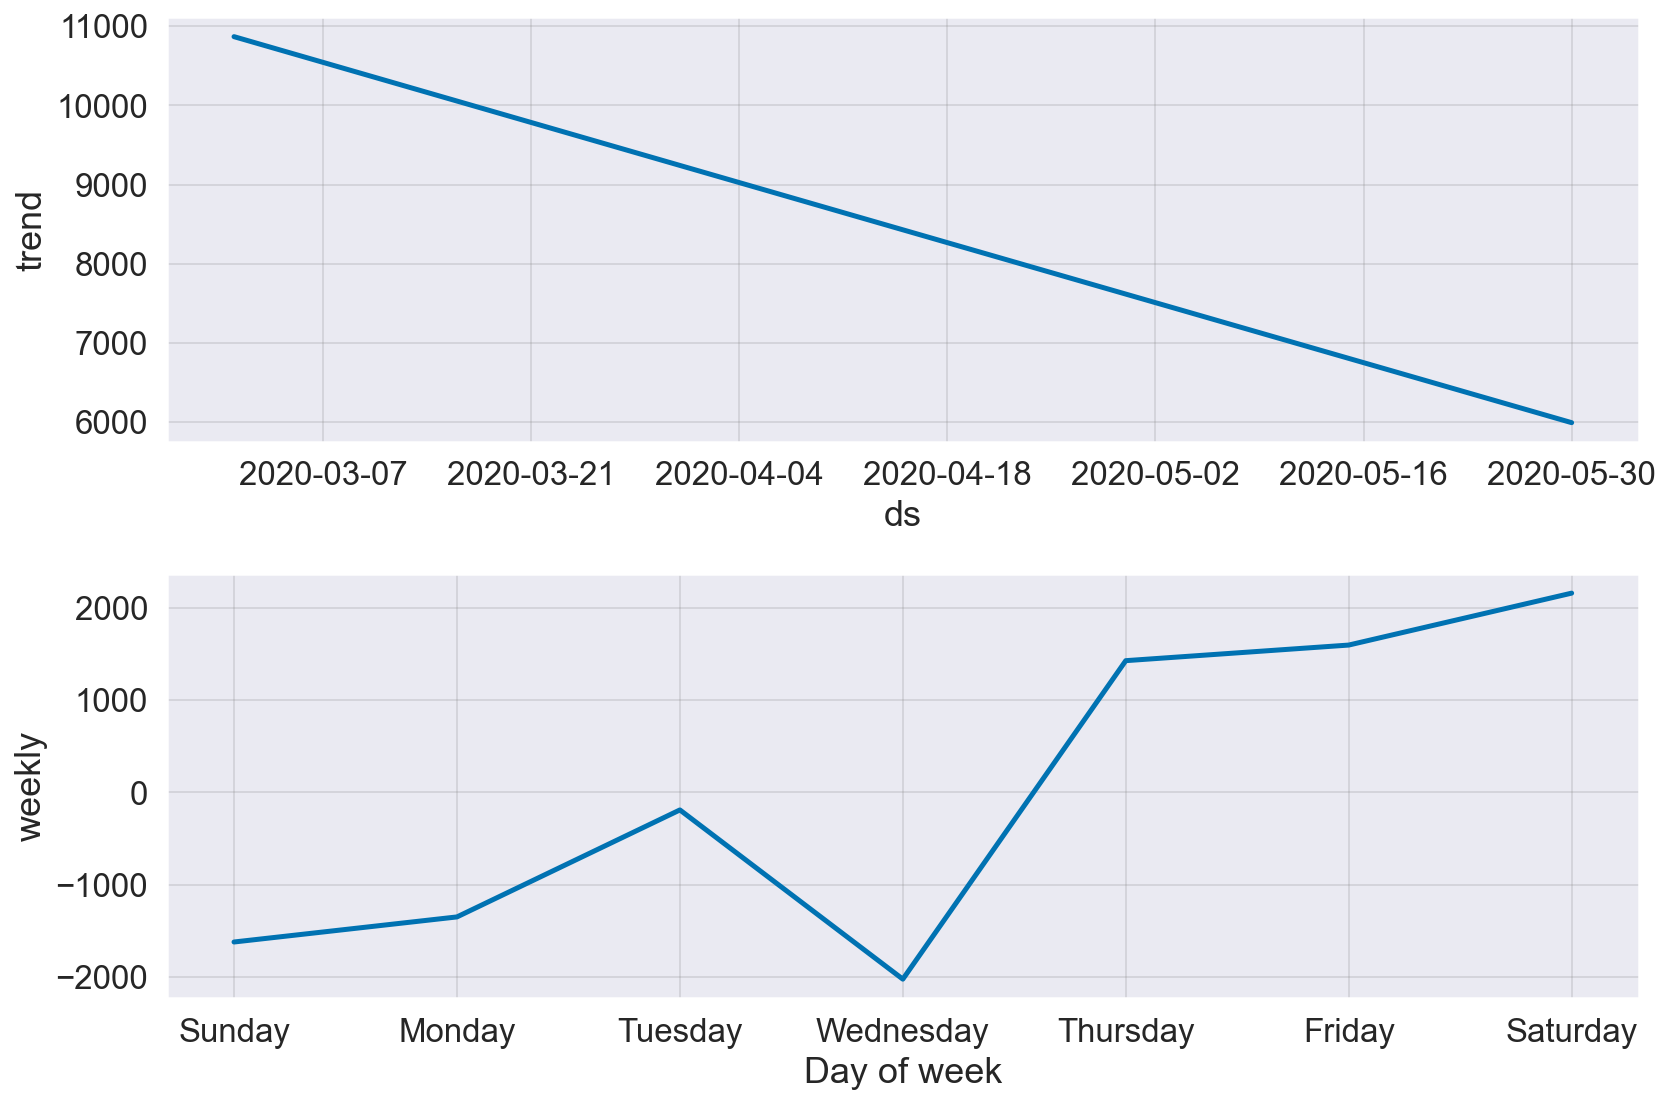

In [10]:
fig = prophet.plot_components(forecast_vendas, figsize=(12,8))


# Modelo Baseado na Decomposição dos Componentes

<div class="alert alert-block alert-info">
<b>Tendência:</b> Os dados apresentam uma tendência de queda da quantidade de produtos vendidos.
<p><b>Componente Semanal:</b> Nesse componente observamos um volume negativo de produtos vendidos entre domingo e quarta.
Isso ocorre em função da sazonalidade semanal e diária que ainda não foi identificada corretamente e as grandes
variações nas quantidades de produtos vendidos entre os meses de março e os seguintes. Esses fatores podem ser os que
apresentam maior influência nesses resultados. Notamos que a quarta-feira, no modelo previsto, mantém o comportamento
identificado anteriormente nos dados reais.</p>
</div>

##### Gráfico da previsão gerada

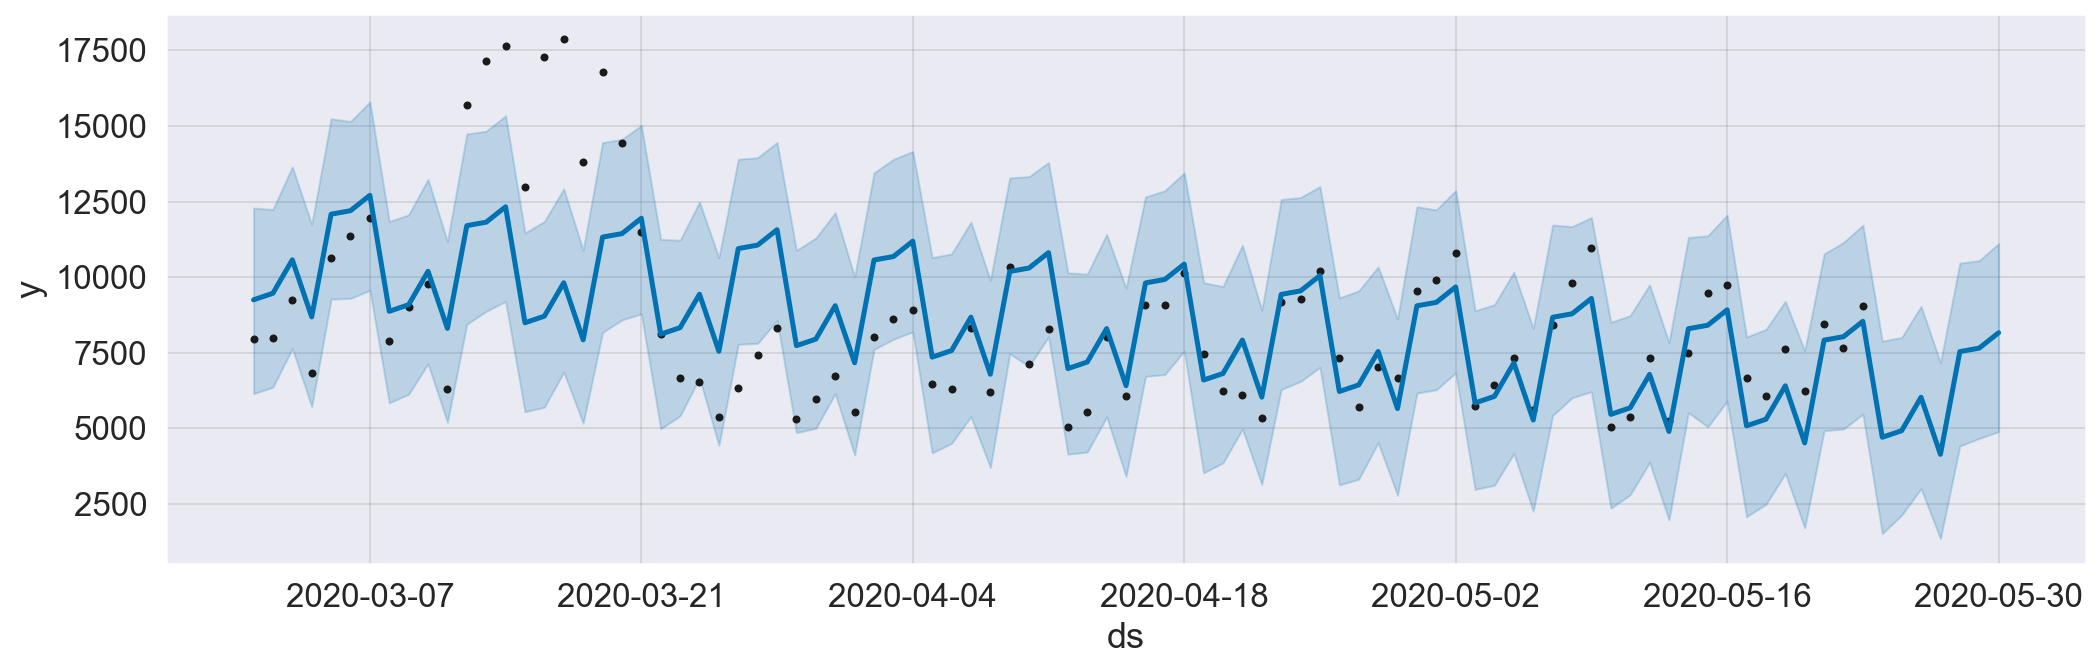

In [11]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_vendas,ax=ax)
plt.show()

<div class="alert alert-block alert-info">
<b>Gráfico do modelo previsto:</b> Os pontos escuros no gráfico representam os dados reais e na altura da segunda semana
de março, observamos dados que escapam do modelo previsto indicando possíveis outliers. As linhas azuis mais escura,
representam a previsão de volumes de produtos vendidos enquanto as linhas mais claras representam o intervalo de
confiança em torno da previsão.
</div>

##### Gerando a previsão para o dataframe de teste com o modelo treinado

In [12]:
df_274_sale_teste_diario_forecast = prophet.predict(df_274_sale_teste_diario)
iplot(dtview.plot_forecast_as_table(df_274_sale_teste_diario_forecast))

##### Gráfico da previsão com o dataframe de teste comparado com o dataframe previsto

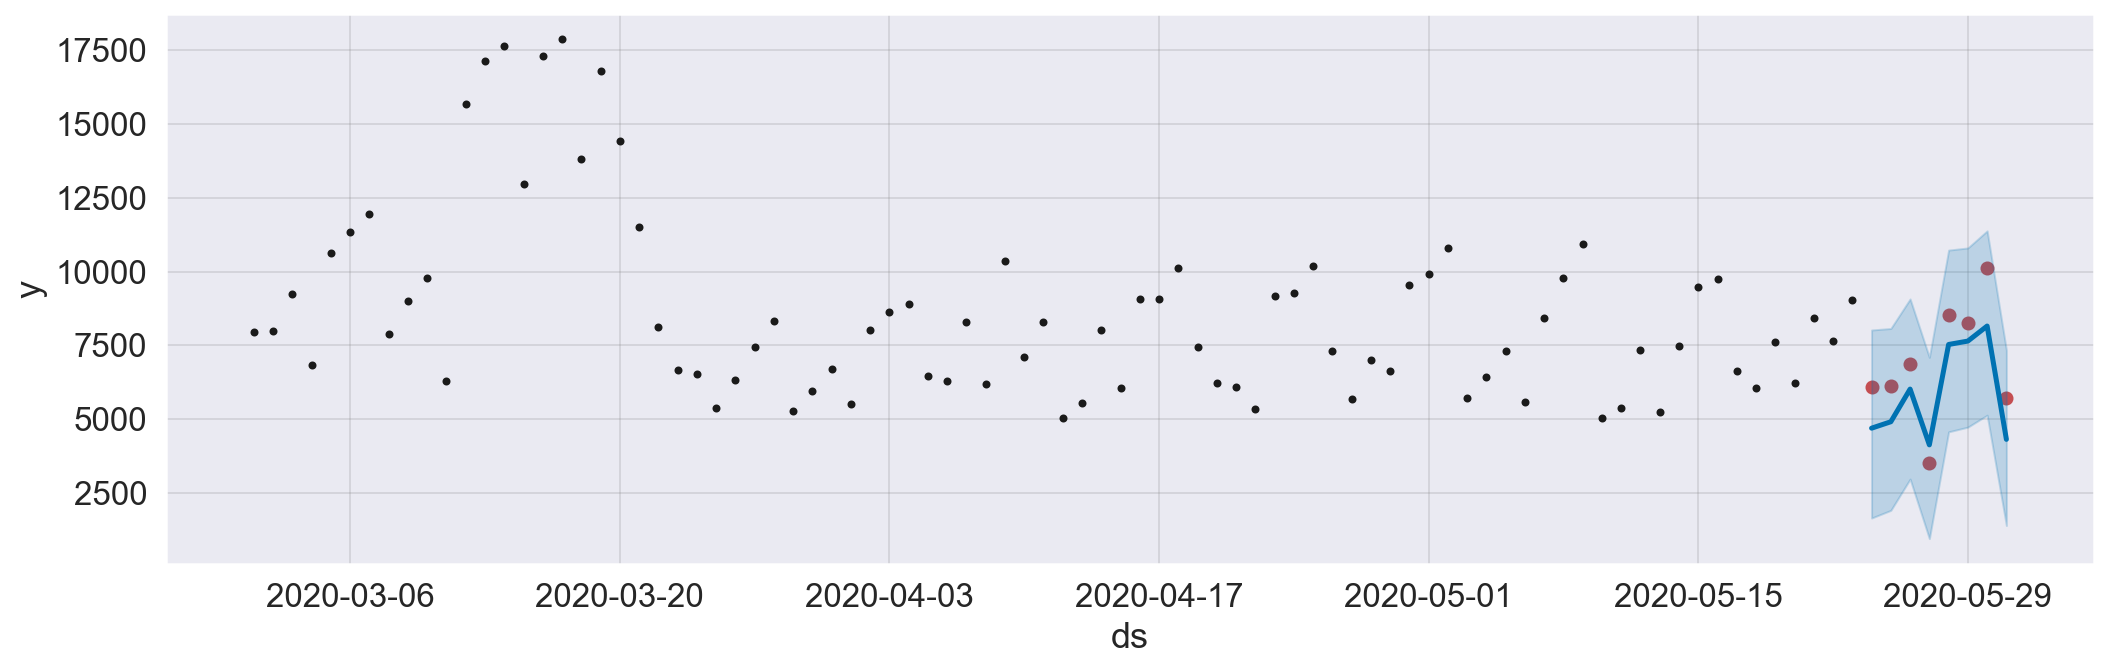

In [13]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste_diario.ds,df_274_sale_teste_diario['y'], color='r')
fig = prophet.plot(df_274_sale_teste_diario_forecast,ax=ax)
plt.show()


# Comparação entre as vendas do dataset previsto e as vendas do dataset de teste (vendas realizadas)

In [14]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste_diario,
                                   df_274_sale_teste_diario_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

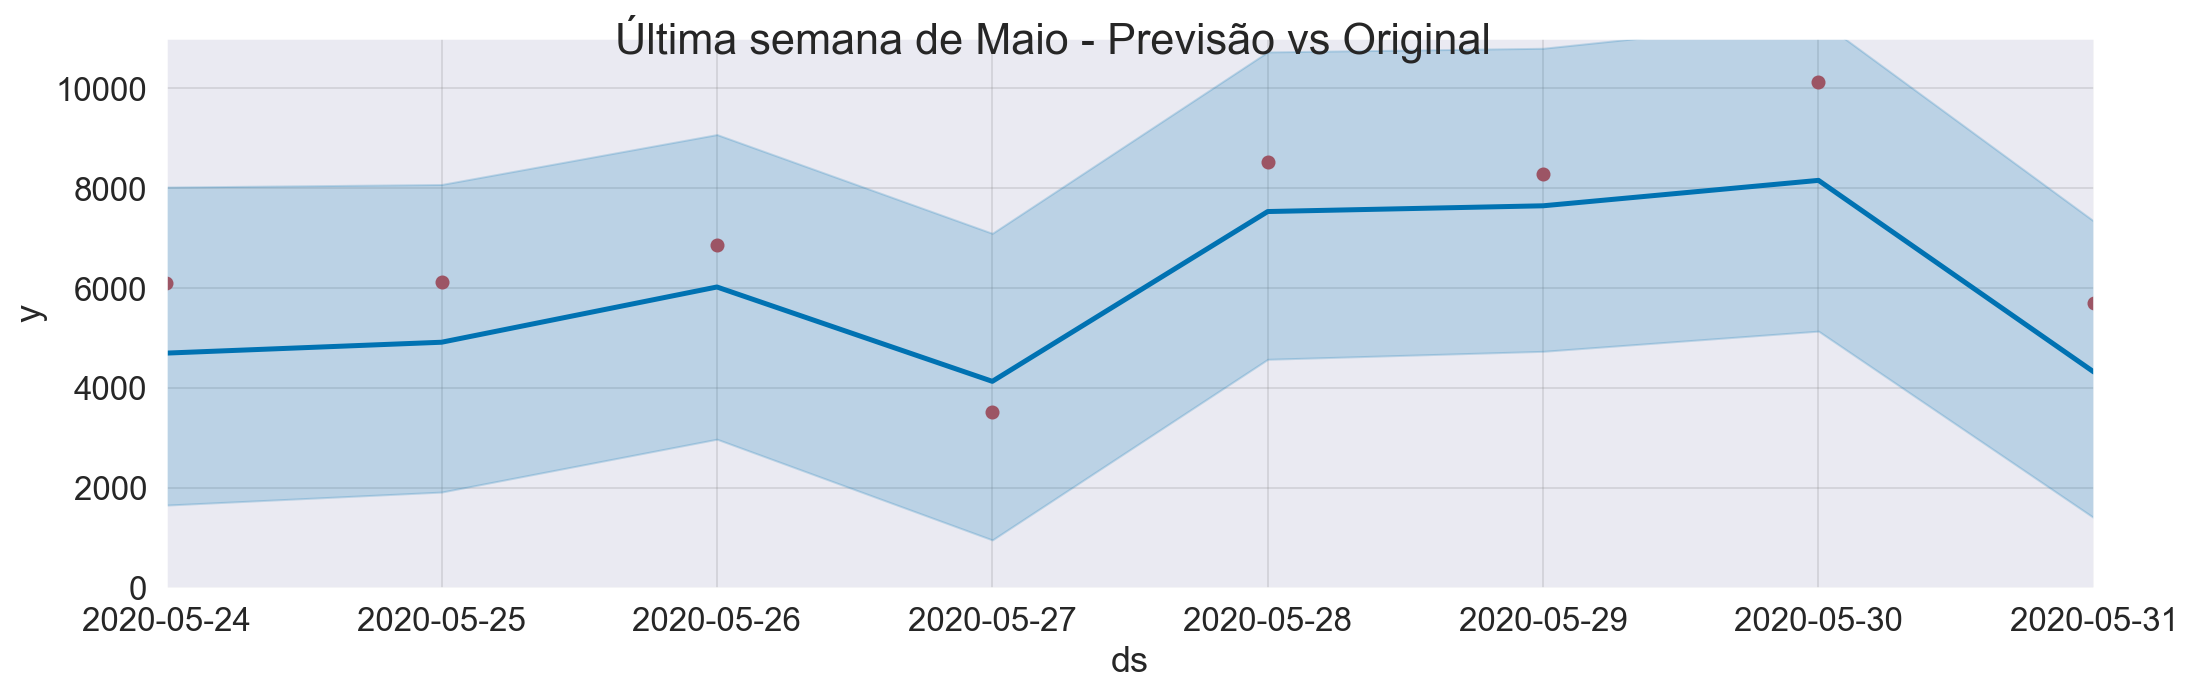

In [15]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste_diario.ds, df_274_sale_teste_diario['y'], color='r')
fig = prophet.plot(df_274_sale_teste_diario_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 11000)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

<div class="alert alert-block alert-info">
<b> A previsão foi feita para a última semana do mês de maio num período de 7 dias. Nesse gráfico verificamos pelos
pontos vermelhos os dados reais e na linha azul ao centro a previsão, a área azul clara representa o intervalo de
confiança da previsão.
</div>

In [16]:
metricas = []
mape_analysis = []
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario['y']),
                                       np.array(df_274_sale_teste_diario_forecast['yhat'])))
metricas.append(
    fm.evaluate(
        np.array(
            df_274_sale_teste_diario['y']),
        np.array(
            df_274_sale_teste_diario_forecast['yhat']),metrics=('mse','mae','rmse')
    ))
print("MAPE -----> {}".format(mape_analysis[0]))

MAPE -----> 0.16899542665715367


In [17]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste_diario,
    df_274_sale_teste_diario_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))

# Criando novo modelo com os feriados

In [18]:

prophet_feriados = Prophet(holidays=dtclean.get_Holiday())
prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_sale_treino_diario)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados = prophet_feriados.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


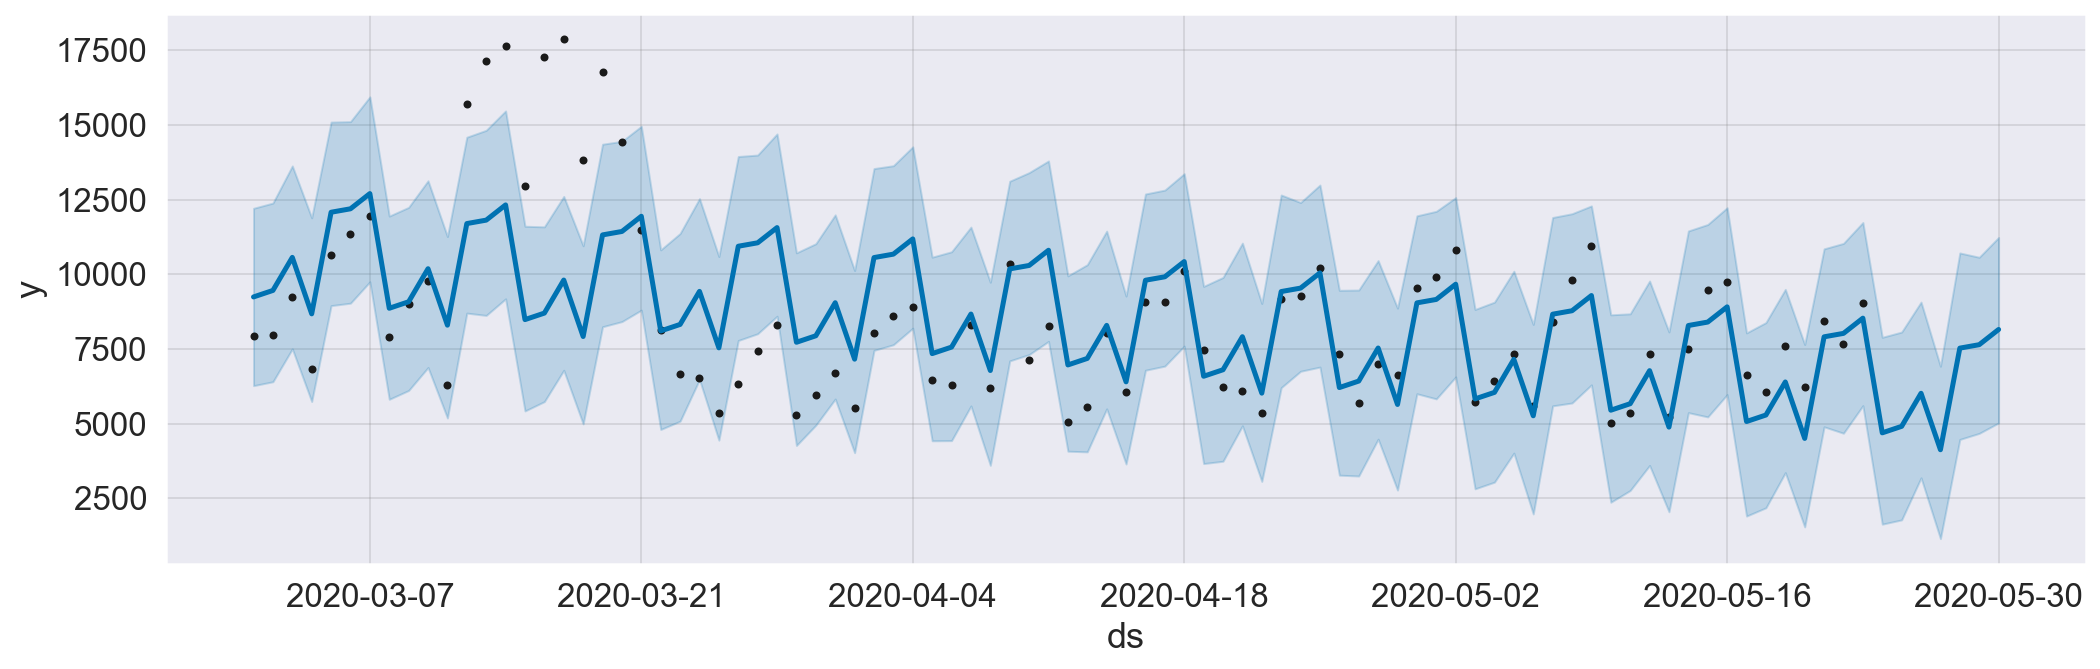

In [19]:
plt,fig_forecast_feriado = dtview.plot_forecast(forecast_feriados,prophet_feriados,f,ax)
plt.show()

<div class="alert alert-block alert-info">
Visualmente não notamos grandes diferenças no gráfico previsto para o novo modelo gerado com feriados. Cabe destacar
que não sabemos os feriados específicos da cidade e sequer eventos que possam impactar na variável em análise, como
dias de jogos de futebol, eventos festivos e etc.
</div>

# Visualizando os componentes do modelo

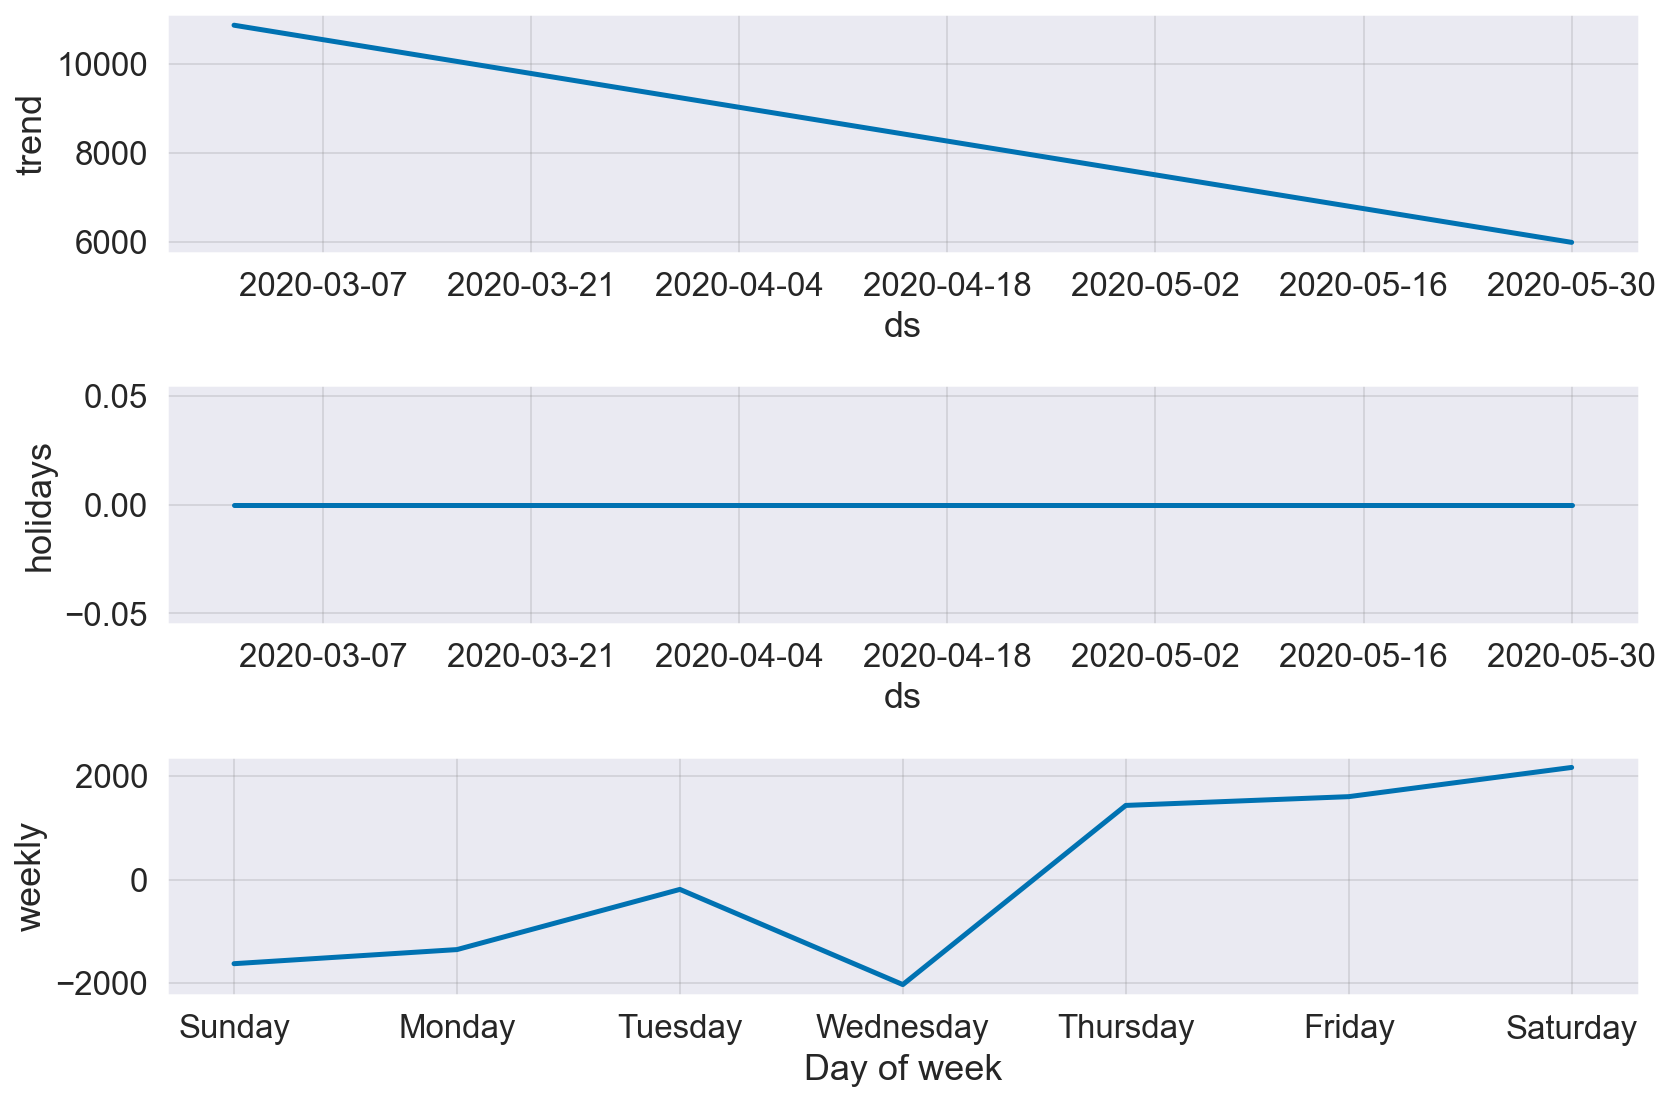

In [20]:
fig_forecast_feriado = prophet_feriados.plot_components(forecast_feriados, figsize=(12,8))

<div class="alert alert-block alert-info">
<b>Componentes:</b> Também não há diferenças nos gráficos de componentes de tendência e semanal, apenas há um novo
componente que representa o feriado que não está a influenciar no volume de produtos vendidos.
</div>

In [21]:
forecast_teste_feriados = prophet_feriados.predict(df_274_sale_teste_diario)

## Visualizar dataframe de teste previsto e original com feriados

In [22]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sale_teste_diario,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [23]:
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario.y), np.array(forecast_teste_feriados.yhat)))
metricas.append(
    fm.evaluate(
        np.array(
            df_274_sale_teste_diario.y),
        np.array(
            forecast_teste_feriados.yhat),metrics=('mse','mae','rmse')
    ))

print("MAPE -----> {}".format(mape_analysis[1]))

MAPE -----> 0.16899542665714887


<div class="alert alert-block alert-info">
Conforme podemos verificar pelo resultado do MAPE, a inclusão dos feriados não modificaram o resultado da previsão, isso
ocorre em função do baixo volume de dados, pois o algoritmo não consegue prever se os feriados influenciam no volume de
produtos vendidos.
</div>

## Realizando tunning nos parâmetros do modelo para melhorar a acurácia.

<div class="alert alert-block alert-info">
Fazemos uma verificação de combinações possíveis de alguns dos parâmetros utilizados pelo Prophet para identificar a
combinação que poderá oferecer melhor acurácia do modelo. Cabe destacar aqui que não foram explorados todos os
parâmetros, visto que há necessidade de obter maiores detalhes com os business experts sobre questões como outliers,
feriados, horários de abertura e encerramento da loja e etc.
</div>

In [24]:
from sklearn.model_selection import ParameterGrid
changepoint = [0.3,0.5,10]
seasonality_prior = [15,20,25]
holidays_prior = [0.3,0.5,10]
n_change = [30,50,66]

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':changepoint,
               'seasonality_prior_scale': seasonality_prior,
              'holidays_prior_scale':holidays_prior,
              'n_changepoints' : n_change}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total de modelos possíveis',cnt)

Total de modelos possíveis 162


In [25]:
iplot(dtview.view_optimum_parameters('model_parameters_274_vendas_diarias.csv'))

In [26]:
'''Utilizar apenas quando prever melhor conjunto de parâmetros. Acessar o arquivo model_parameters_274_vendas_diarias.csv'''
# dtexp.tuning_model(df_274_sale_treino_diario,df_274_sale,periodo=7,frequencia='D',loja='274',tipo='vendas_diarias',
#                    changepoint_prior_scale=[0.3,0.5,10],
#                    seasonality_prior_scale=[15,20,25],
#                    holidays_prior_scale=[0.3,0.5,10])

'Utilizar apenas quando prever melhor conjunto de parâmetros. Acessar o arquivo model_parameters_274_vendas_diarias.csv'

## Treinando o modelo com os melhores parâmetros identificados

+ changepoint_prior_scale= 10
+ holidays_prior_scale = 0.3
+ n_changepoints = 30
+ seasonality_mode = 'multiplicative'
+ seasonality_prior_scale = 15,20,25

##### Configurando e treinando o modelo com feriados e parâmetros otimizados

In [27]:
final_prophet = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 10,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 15,
                      weekly_seasonality=True,
                      daily_seasonality = False,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet.add_country_holidays(country_name='BR')
final_prophet.fit(df_274_sale_treino_diario)

In [28]:
future_final = final_prophet.make_future_dataframe(periods=7, freq='D')
forecast_final = final_prophet.predict(future_final)

##### Visualizando os componentes do modelo

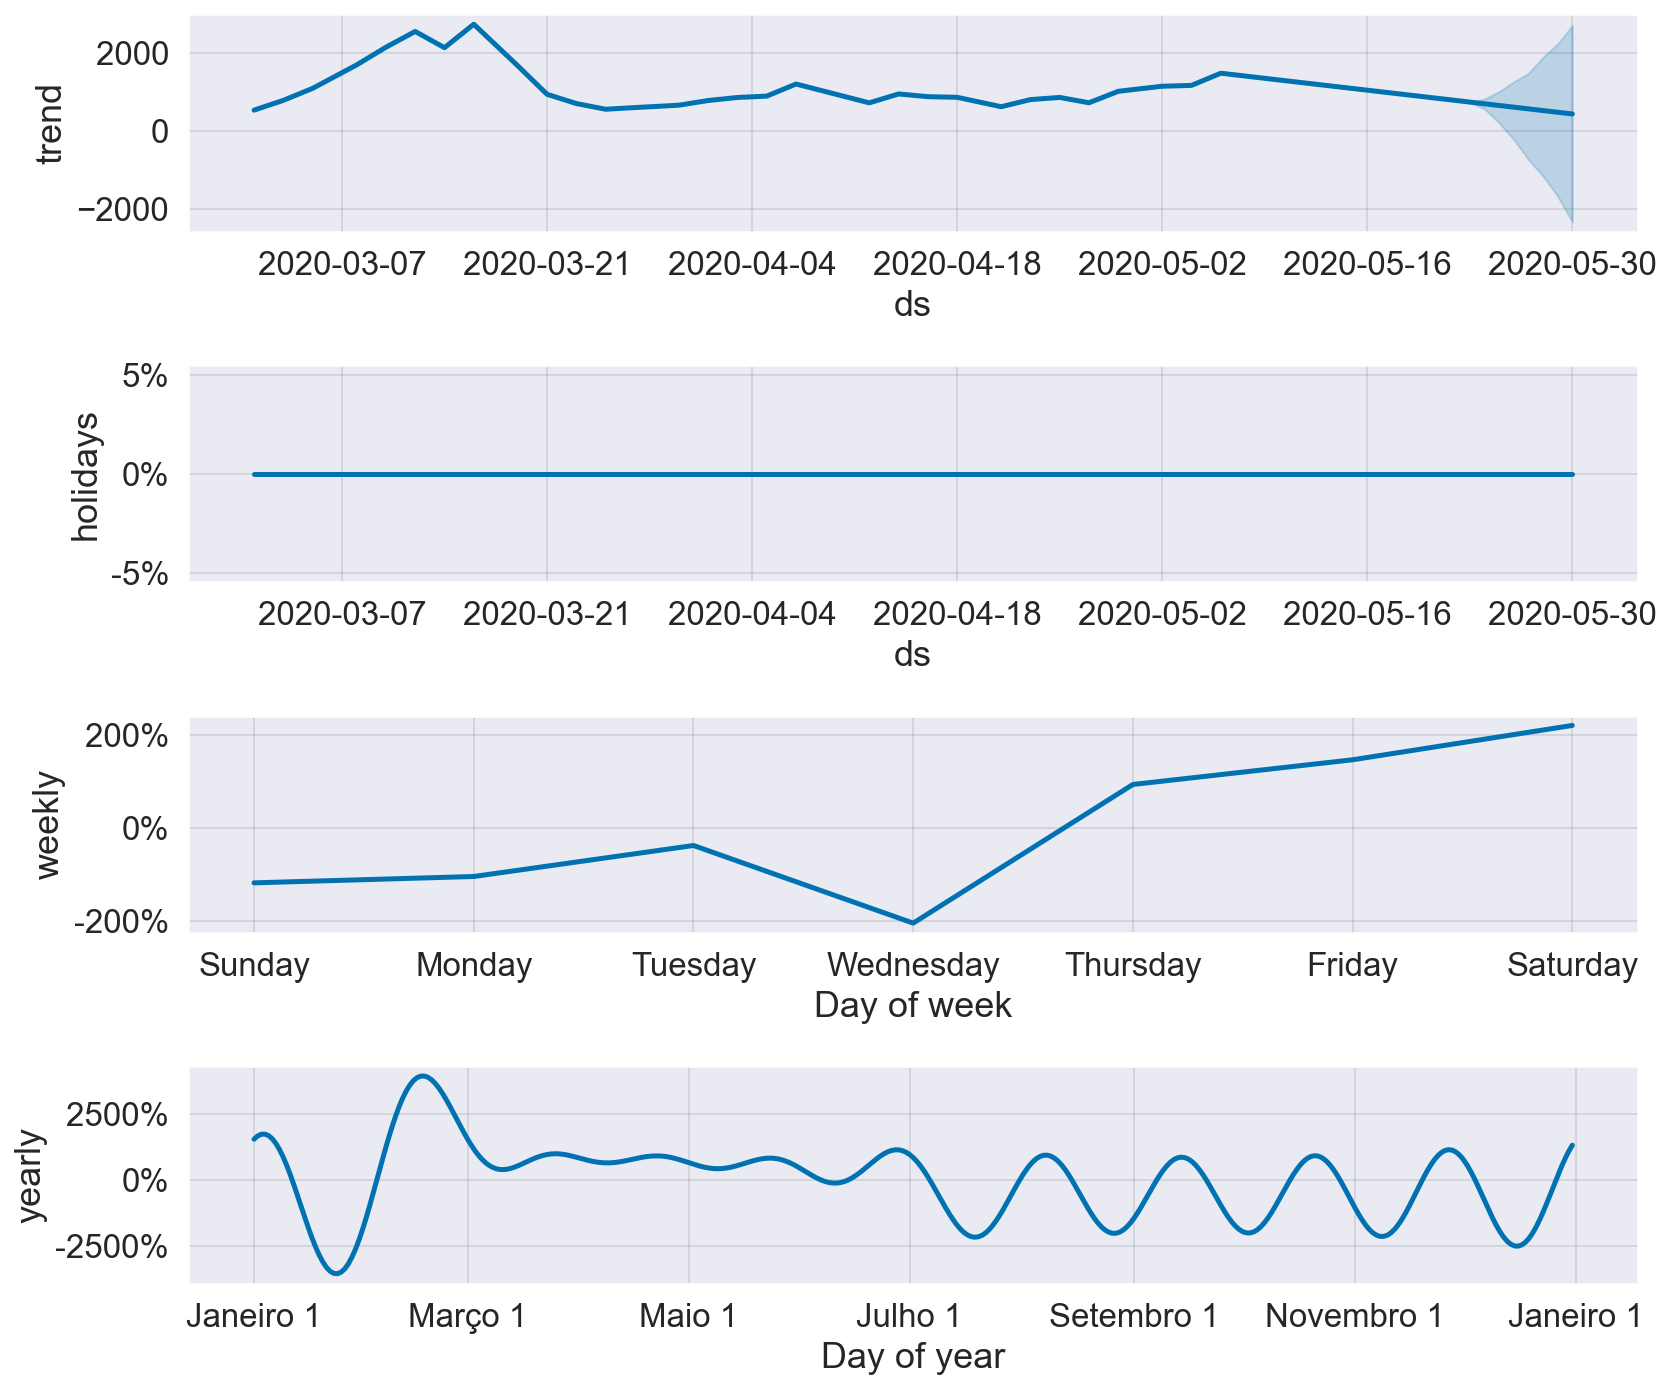

In [29]:
fig = final_prophet.plot_components(forecast_final, figsize=(12,10))

<div class="alert alert-block alert-info">
Na plotagem dos componentes, observamos que o eixo y do componente semanal teve uma redução. Esse eixo representa o
quanto o dia da semana afeta ou impacta na previsão, antes dos parâmetros tunados e sem adição dos feriados, era
superior a 2000 % e agora reduziu para 250%. Entre domingo e quinta-feira há uma variação que supera 250% para a
sazonalidade semanal e na sazonalidade anual, há uma variação superior a 5000% entre fevereiro e março, essas variações
são as responsáveis por verificarmos valores negativos na previsão. Um teste para tratar essa situação poderá ser a
separação do dataset em um dataset para a semana útil e outro para fins de semana, para verificar se há melhora na
acurácia e remoção dos valores negativos.
</div>

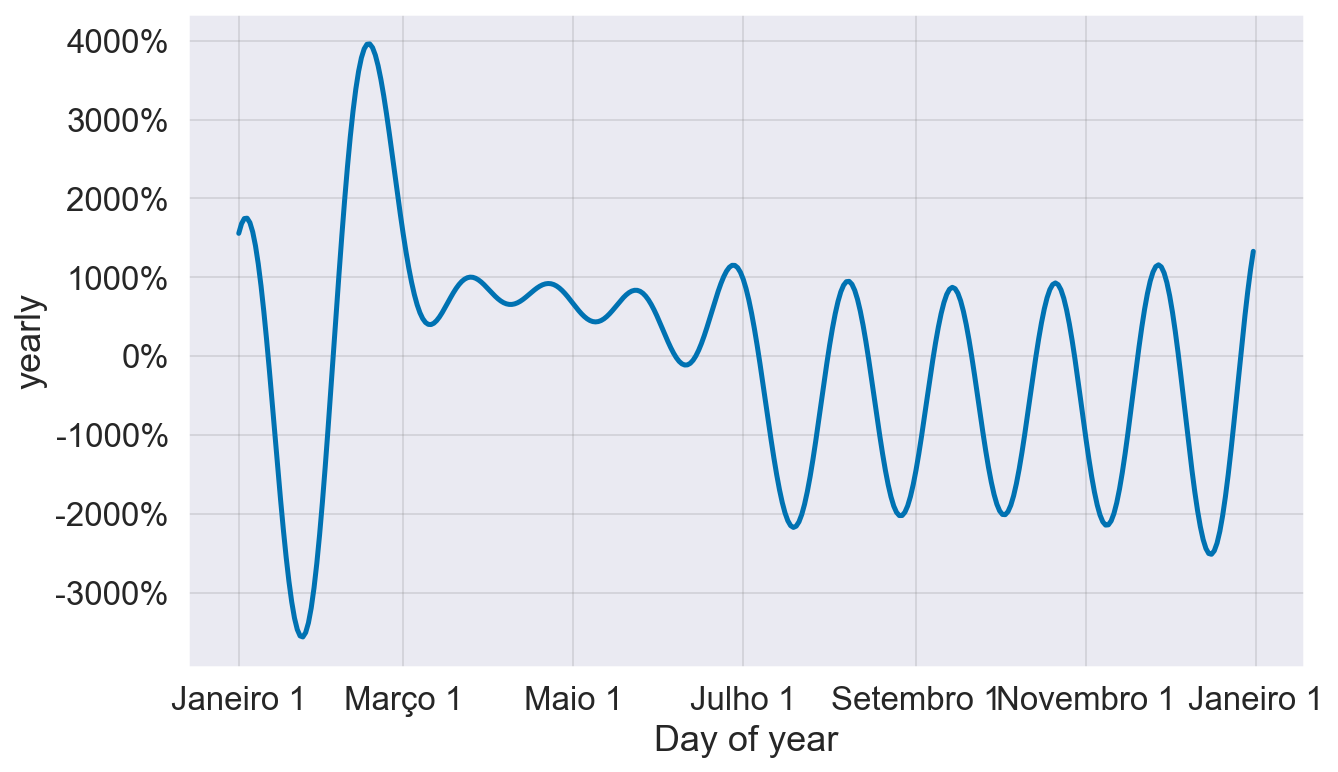

In [30]:
from fbprophet.plot import plot_weekly,plot_yearly

fig_y = plot_yearly(final_prophet)

<div class="alert alert-block alert-info">
Em função do baixo volume de dados, a previsão anual possui grande incerteza tornando as variações de sazonalidade muito
grande entre si, somado a isso há um volume de produtos vendidos no mês de março que se destacou de forma exagerada da
média de valores de todo o dataset.
</div>

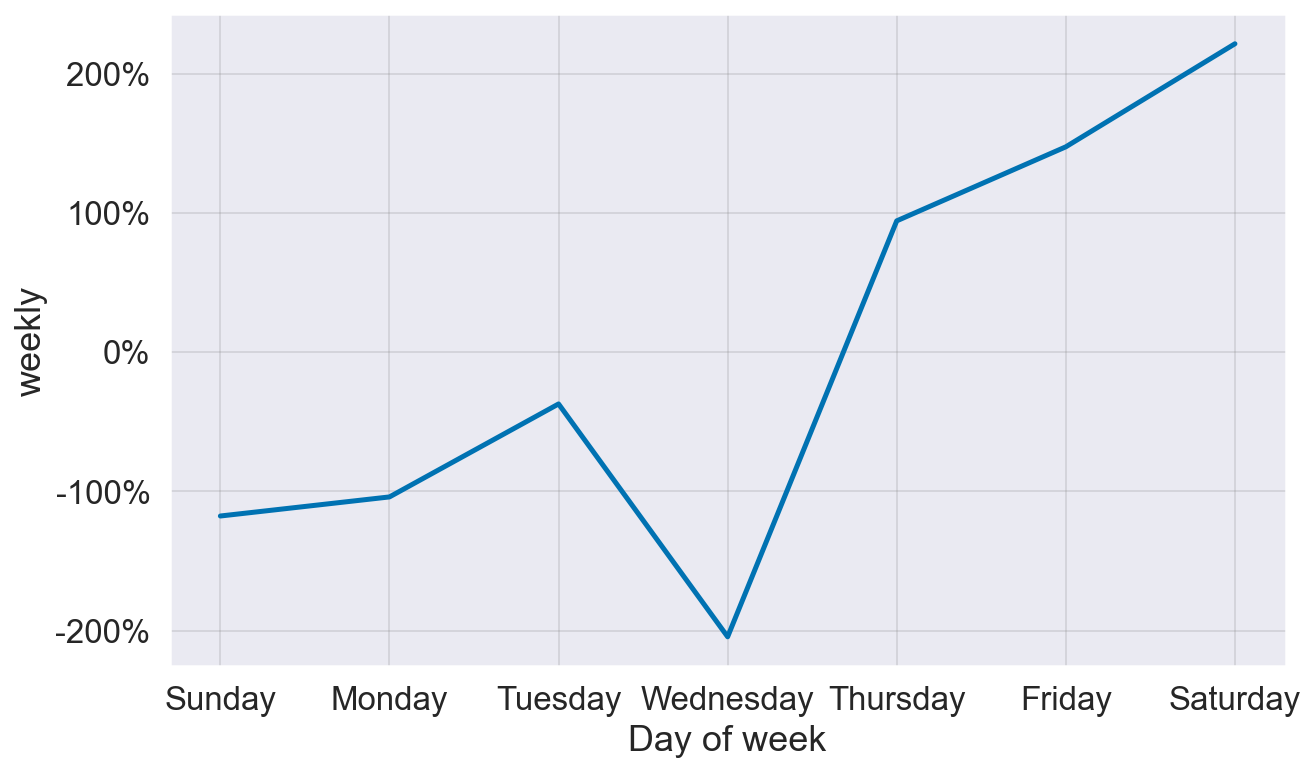

In [31]:
fig_w = plot_weekly(final_prophet)

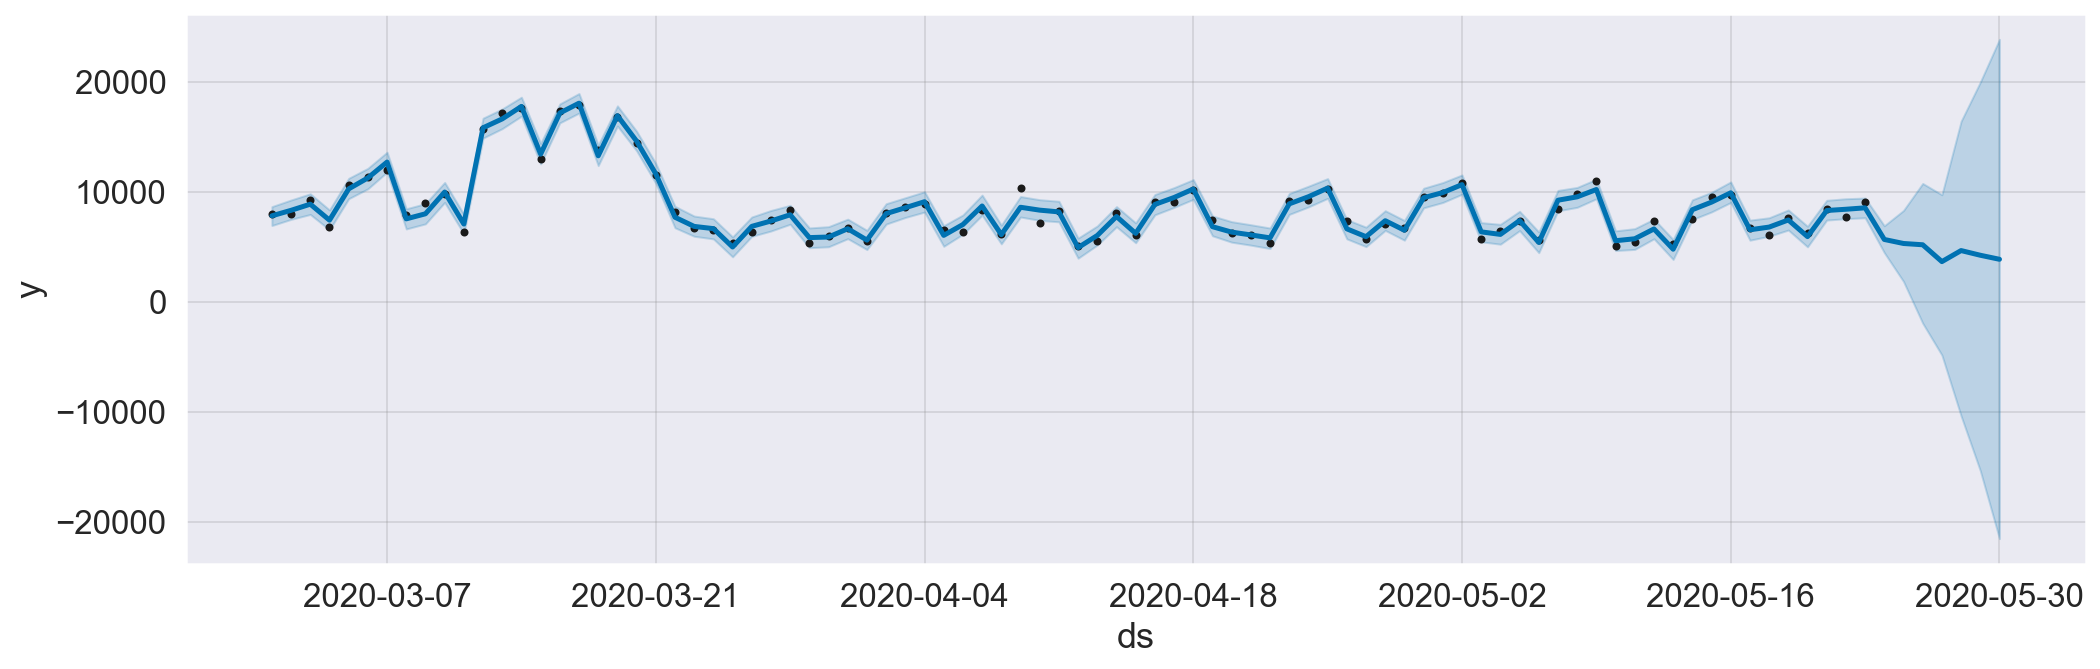

In [32]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet.plot(forecast_final,ax=ax)
plt.show()

In [33]:
df_teste_final= final_prophet.predict(df_274_sale_teste_diario)
iplot(dtview.plot_forecast_as_table(df_teste_final))

In [34]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste_diario,
                                   df_teste_final,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

# Comparando os dataframes de teste e previsto em escala diária

In [35]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste_diario,
    df_teste_final,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [36]:
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario.y), np.array(df_teste_final.yhat)))
metricas.append(
    fm.evaluate(
        np.array(
            df_274_sale_teste_diario.y),
        np.array(
            df_teste_final.yhat),metrics=('mse','mae','rmse')
    ))
print("MAPE -----> {}".format(mape_analysis[2]))

MAPE -----> 0.3414754220028371


# Identificando os outliers

<div class="alert alert-block alert-info">
Como não sabemos se há alguma justificativa para os dados candidatos a outliers do conjunto analisado, adotamos a
abordagem visual por box plots para identificar os outliers e removê-los do dataset a fim de comparar os resultados
sem os outliers. Esta é uma análise prévia e não deve ser tomada como solução definitiva para alcançar os resultados
de melhor desempenho, apenas serve de observação para esse estudo.
</div>

In [37]:
dtview.check_outliers_univariate(df_274_sale)

In [38]:
df_sem_outliers = df_274_sale[df_274_sale['y'] < 15689]

###### A visualização gráfica desses valores em boxplot auxilia a compreender o quanto eles estão distante do valor esperado. A caixa de cor sólida, representa os valores esperados, isto é, o maior conjunto de valores que se repete na série, enquanto os pontos fora da caixa representam os outliers.
`Conforme esclarece Montgomery, os outliers são pontos de dados incomuns que devem ser devidamente identificados para análise futura`

In [39]:
df_274_sem_outliers_treino, df_274_sem_outliers_teste = dtexp.configura_dataframe_treino_teste(df_sem_outliers)
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_sem_outliers_treino.shape))
print('Shape dataframe de teste --> {}'.format(df_274_sem_outliers_teste.shape))
print('-'*60)


------------------------------------------------------------
Shape dataframe de treino --> (78, 2)
Shape dataframe de teste --> (8, 2)
------------------------------------------------------------


In [40]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_treino,
                                   df_274_sem_outliers_teste,
                                   title='Montante de dados de vendas de Treinamento e Teste (sem outliers)',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [41]:
prophet_no_outliers = Prophet()
prophet_no_outliers.fit(df_274_sem_outliers_treino)
future_no_outliers = prophet_no_outliers.make_future_dataframe(periods=7, freq='D')
forecast_no_outliers = prophet_no_outliers.predict(future_no_outliers)

iplot(dtview.plot_forecast_as_table(forecast_no_outliers))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


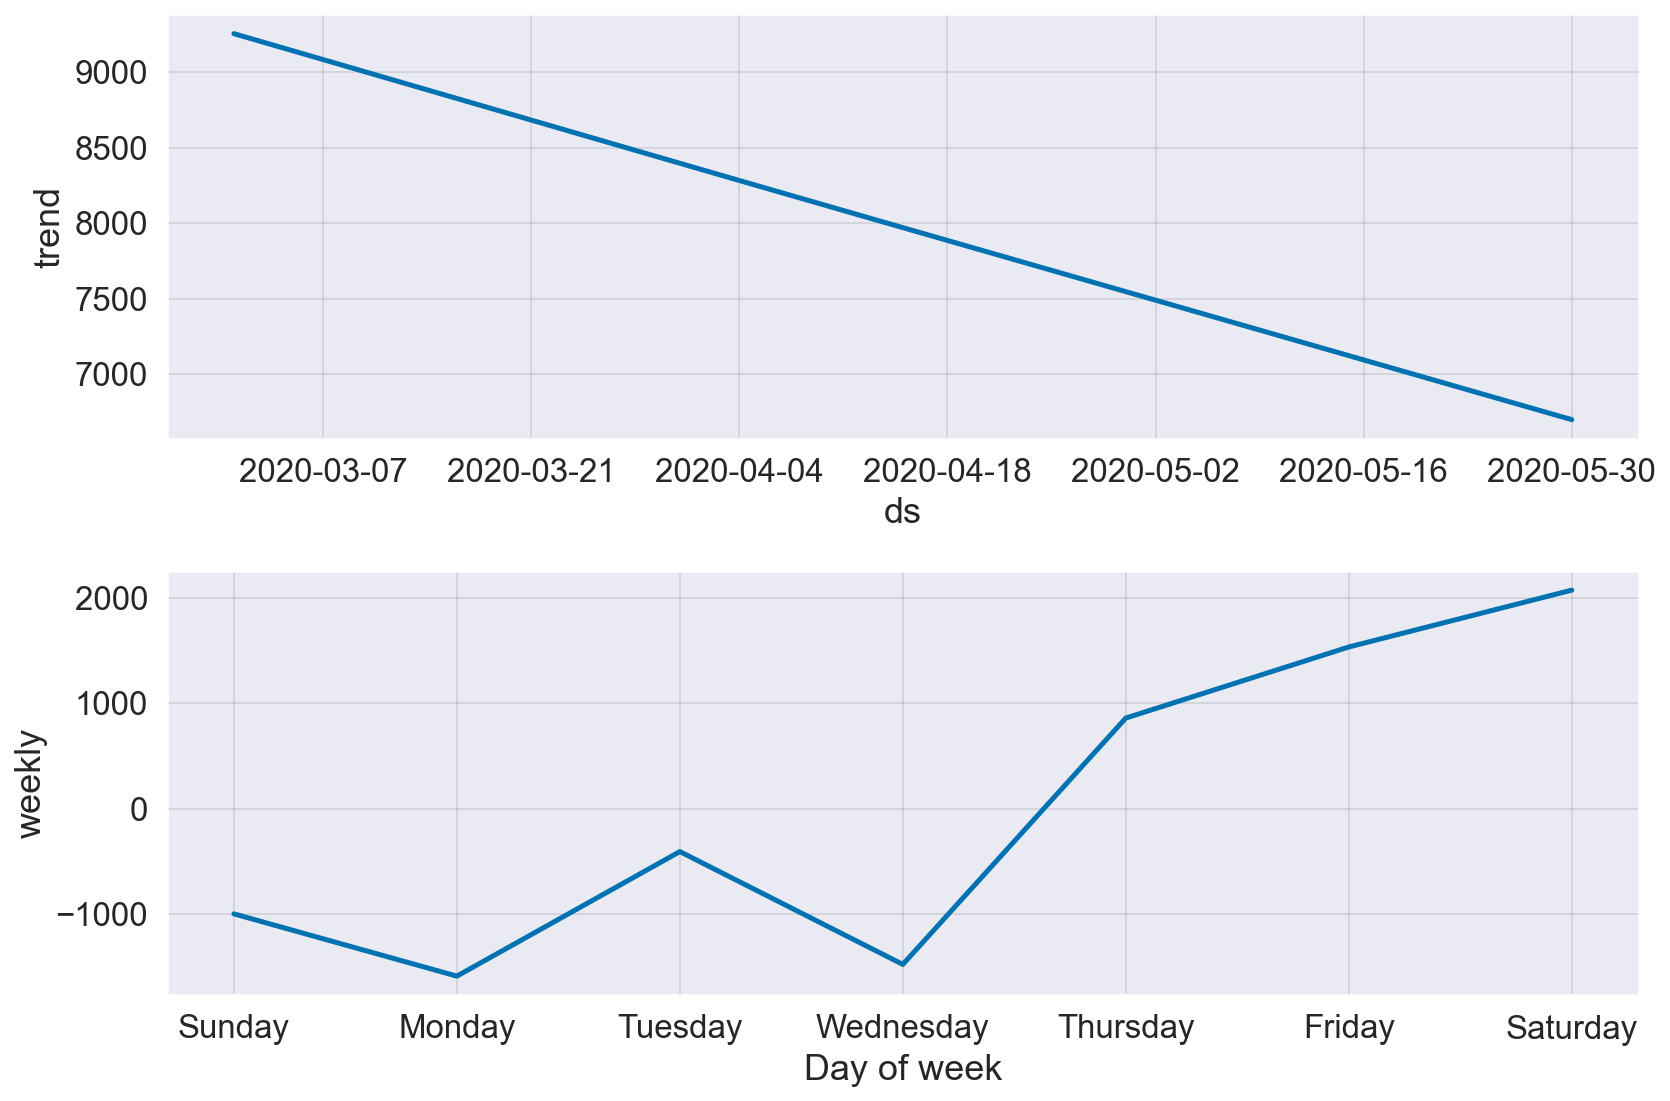

In [42]:
# componentes

fig = prophet_no_outliers.plot_components(forecast_no_outliers, figsize=(12,8))


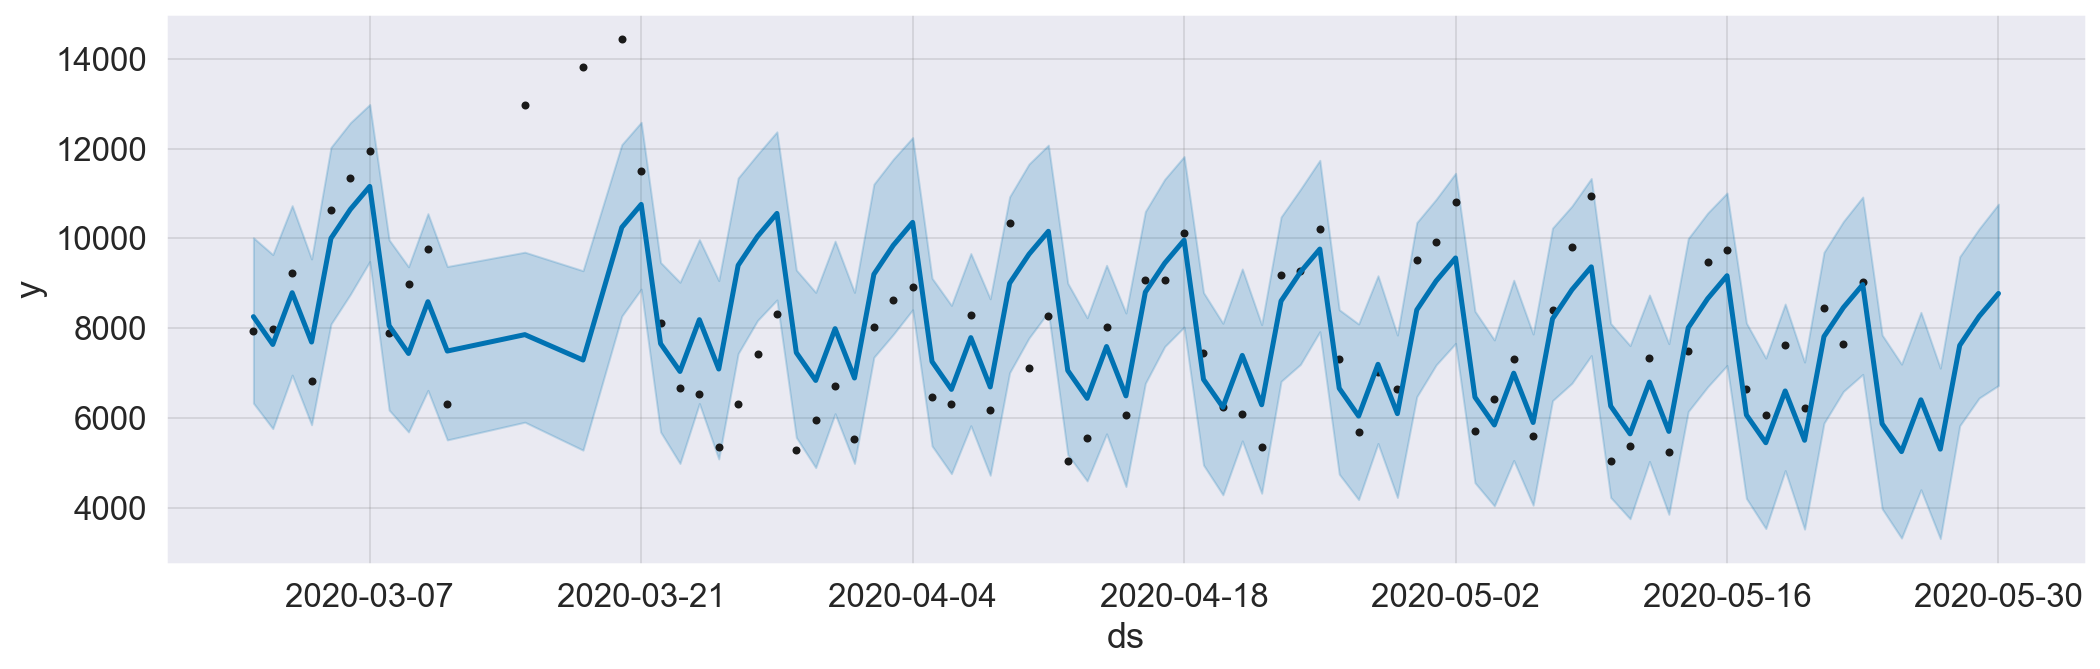

In [43]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_no_outliers.plot(forecast_no_outliers,ax=ax)
plt.show()

In [44]:
df_274_no_outliers_teste_forecast = prophet_no_outliers.predict(df_274_sem_outliers_teste)

In [45]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_274_no_outliers_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

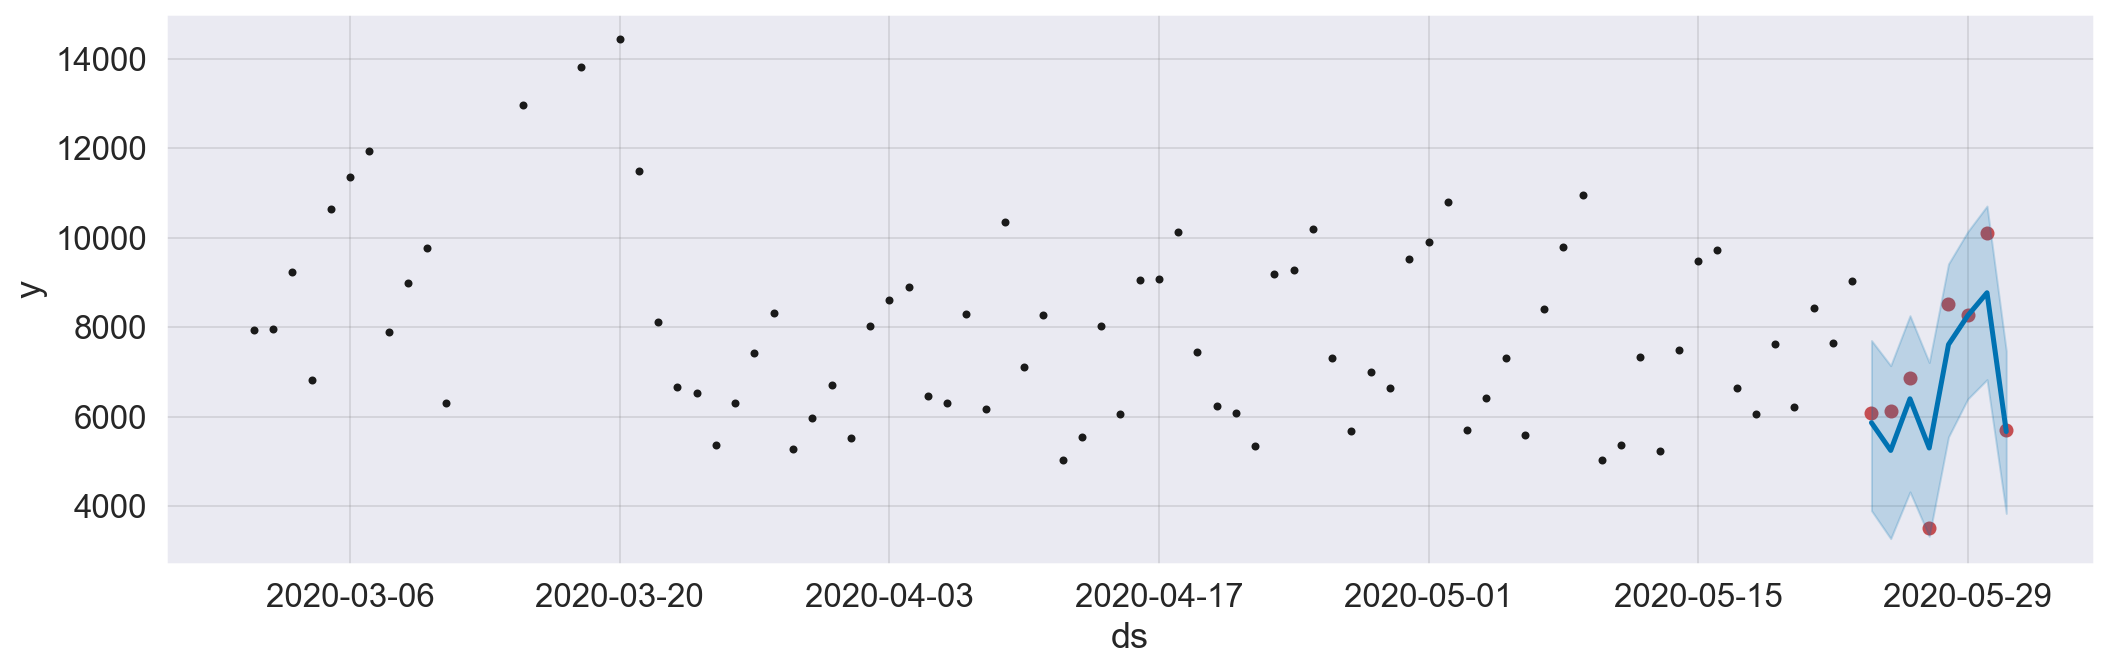

In [46]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds,df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast,ax=ax)
plt.show()

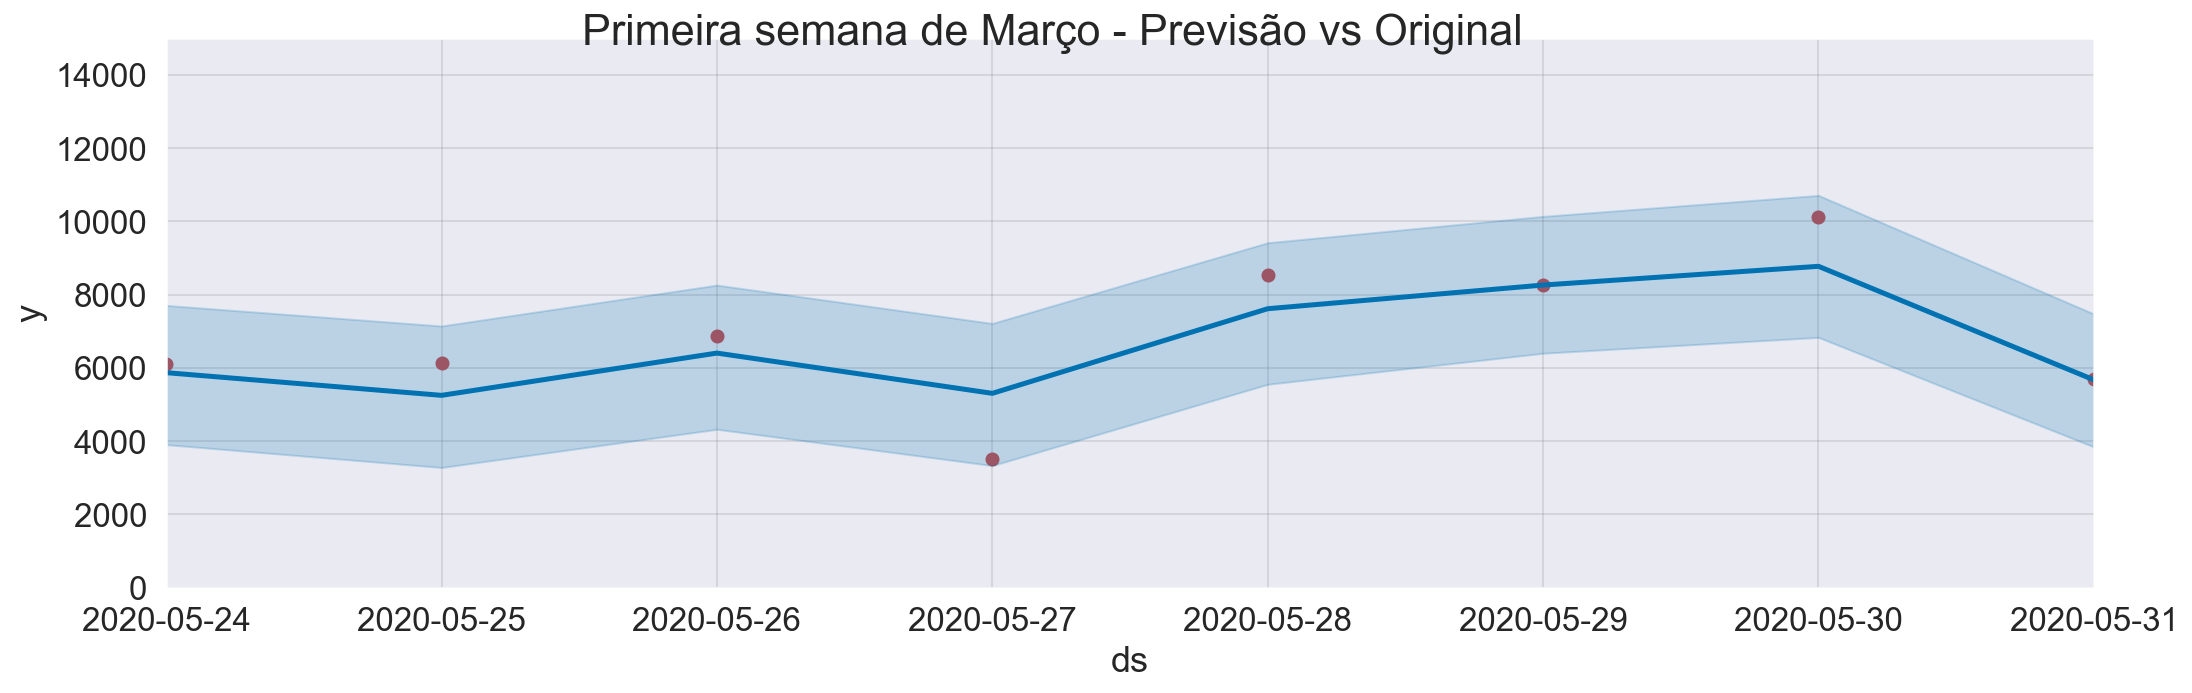

In [47]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds, df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 15000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [48]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste.y),
                               np.array(df_274_no_outliers_teste_forecast.yhat)))
metricas.append(
    fm.evaluate(
        np.array(
            df_274_sem_outliers_teste.y),
        np.array(
            df_274_no_outliers_teste_forecast.yhat),metrics=('mse','mae','rmse')
    ))

print("MAPE -----> {}".format(mape_analysis[3]))

MAPE -----> 0.12482887010004967


In [49]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        df_274_no_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

In [50]:
prophet_feriados_s_outliers = Prophet(holidays=dtclean.get_Holiday())
prophet_feriados_s_outliers.add_country_holidays('BR')
prophet_feriados_s_outliers.fit(df_274_sem_outliers_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados_s_outliers = prophet_feriados_s_outliers.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)
# Previsão optimizada dos valores
future_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


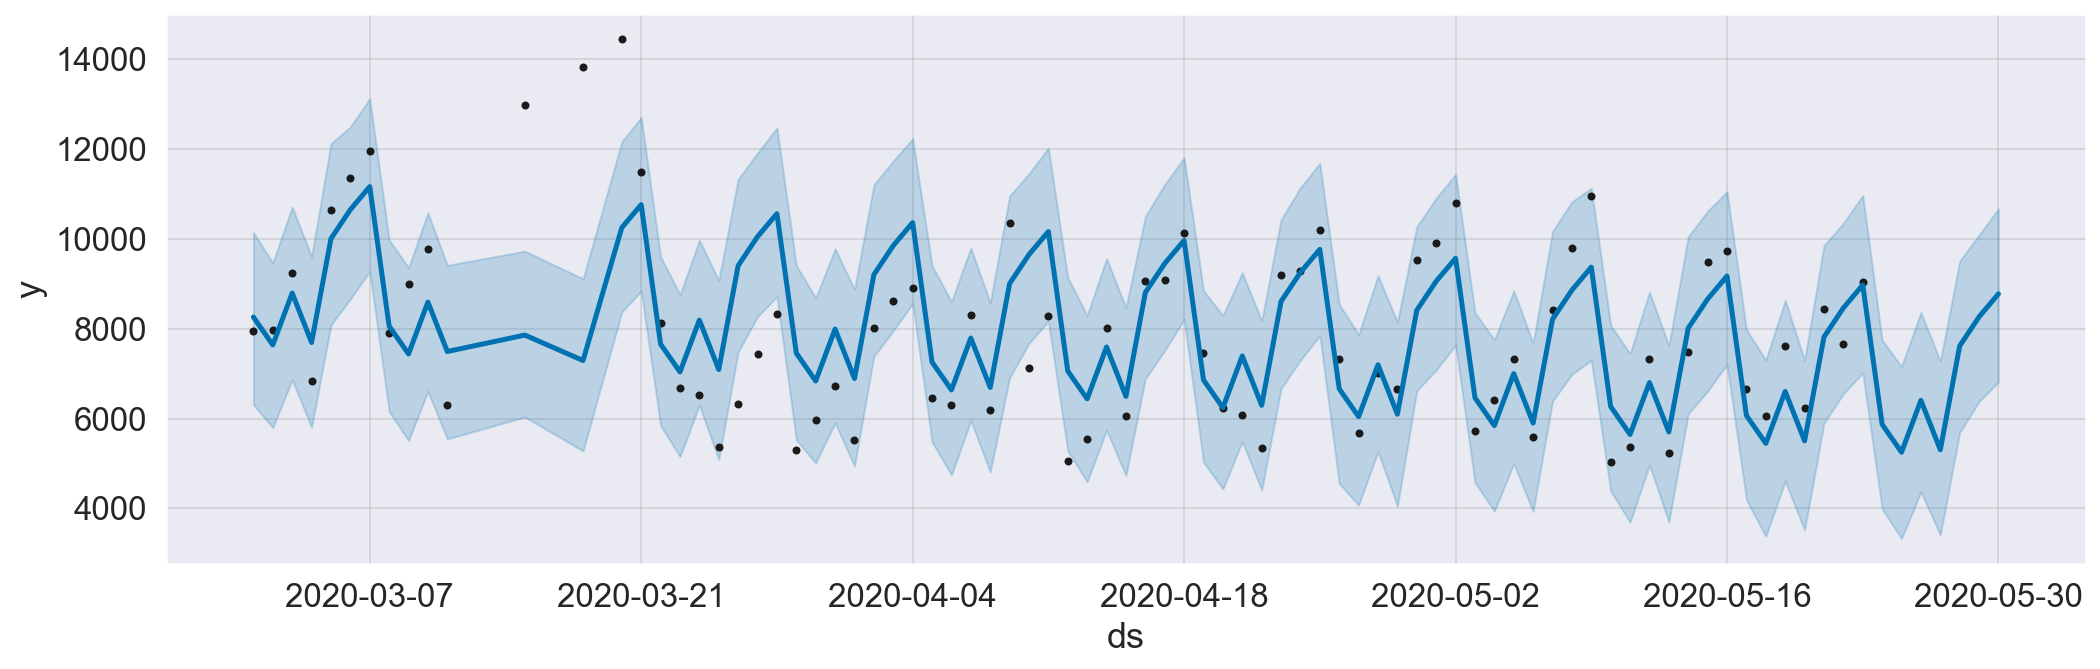

In [51]:
plt,fig_forecast_feriado_s_outliers = dtview.plot_forecast(future_feriados_s_outliers,prophet_feriados_s_outliers,f,ax)
plt.show()

# Visualizando os componentes do modelo

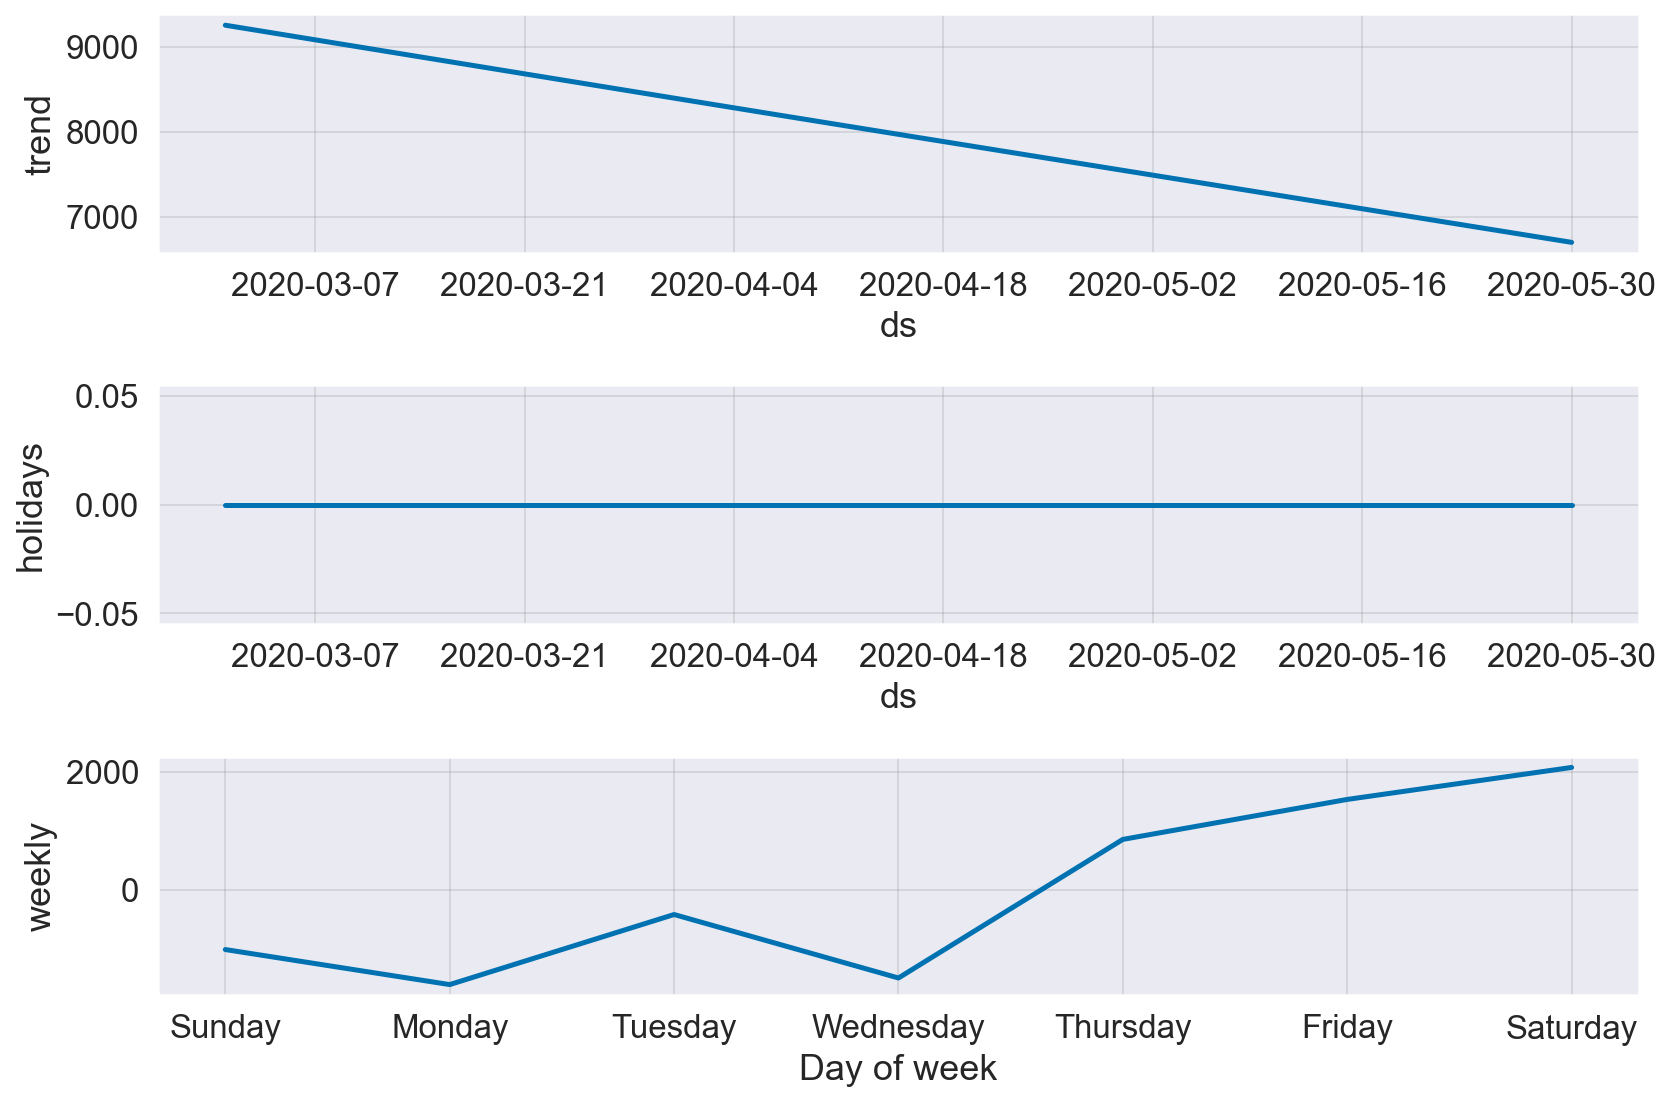

In [52]:
fig_forecast_feriado_s_outliers = prophet_feriados_s_outliers.plot_components(forecast_feriados_s_outliers,figsize=(12,8))

In [53]:
forecast_teste_feriados_s_outliers = prophet_feriados_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(forecast_teste_feriados_s_outliers))

# Visualizar dataframe de teste previsto e original com feriados

In [54]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sem_outliers_teste,
    forecast_teste_feriados_s_outliers,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [55]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        forecast_teste_feriados_s_outliers,
        nametrace1='Original',
        nametrace2='Previsão com feriados',
        idx_end=28))

In [56]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste['y']),
                     np.array(forecast_teste_feriados_s_outliers['yhat'])))
metricas.append(
    fm.evaluate(
        np.array(
            df_274_sem_outliers_teste.y),
        np.array(
            forecast_teste_feriados_s_outliers.yhat),metrics=('mse','mae','rmse')
    ))
print("MAPE -----> {}".format(mape_analysis[4]))

MAPE -----> 0.12482887010004917


In [57]:
# Somente utilizar para gerar novo conjunto otimizado de parâmetros atualmente esse conjunto está registado no arquivo:
# 'model_parameters_274_vendas_s_outliers.csv'
#dtexp.tuning_model(
#    df_274_sem_outliers_treino,
#    df_sem_outliers,
#    periodo=7,
#    frequencia='D',
#    loja='274',
#    tipo='vendas_s_outliers')

In [58]:
parameters_df_s_outliers = pd.read_csv('model_parameters_274_vendas_s_outliers.csv',sep='\t')
parameters_df_s_outliers = parameters_df_s_outliers.sort_values(by=['MAPE'])
parameters_df_s_outliers = parameters_df_s_outliers.reset_index(drop=True)
parameters_df_s_outliers.drop(['Unnamed: 0'],axis=1,inplace=True)
trace_df_parameters_s_outliers=go.Table(header=dict(values=list(parameters_df_s_outliers[['MAPE','Parameters']])),
                            cells=dict(values=[parameters_df_s_outliers.MAPE,
                                               parameters_df_s_outliers.Parameters]))
data=[trace_df_parameters_s_outliers]
fig_df_parameters_s_outliers=go.Figure(data=data)
iplot(fig_df_parameters_s_outliers)

In [59]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet_s_outliers = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 10,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 25,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet_s_outliers.add_country_holidays(country_name='BR')
final_prophet_s_outliers.fit(df_274_sem_outliers_treino)

In [60]:
future_final_s_outliers = final_prophet_s_outliers.make_future_dataframe(periods=7, freq='D')
forecast_final_s_outliers = final_prophet_s_outliers.predict(future_final_s_outliers)
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

In [61]:
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

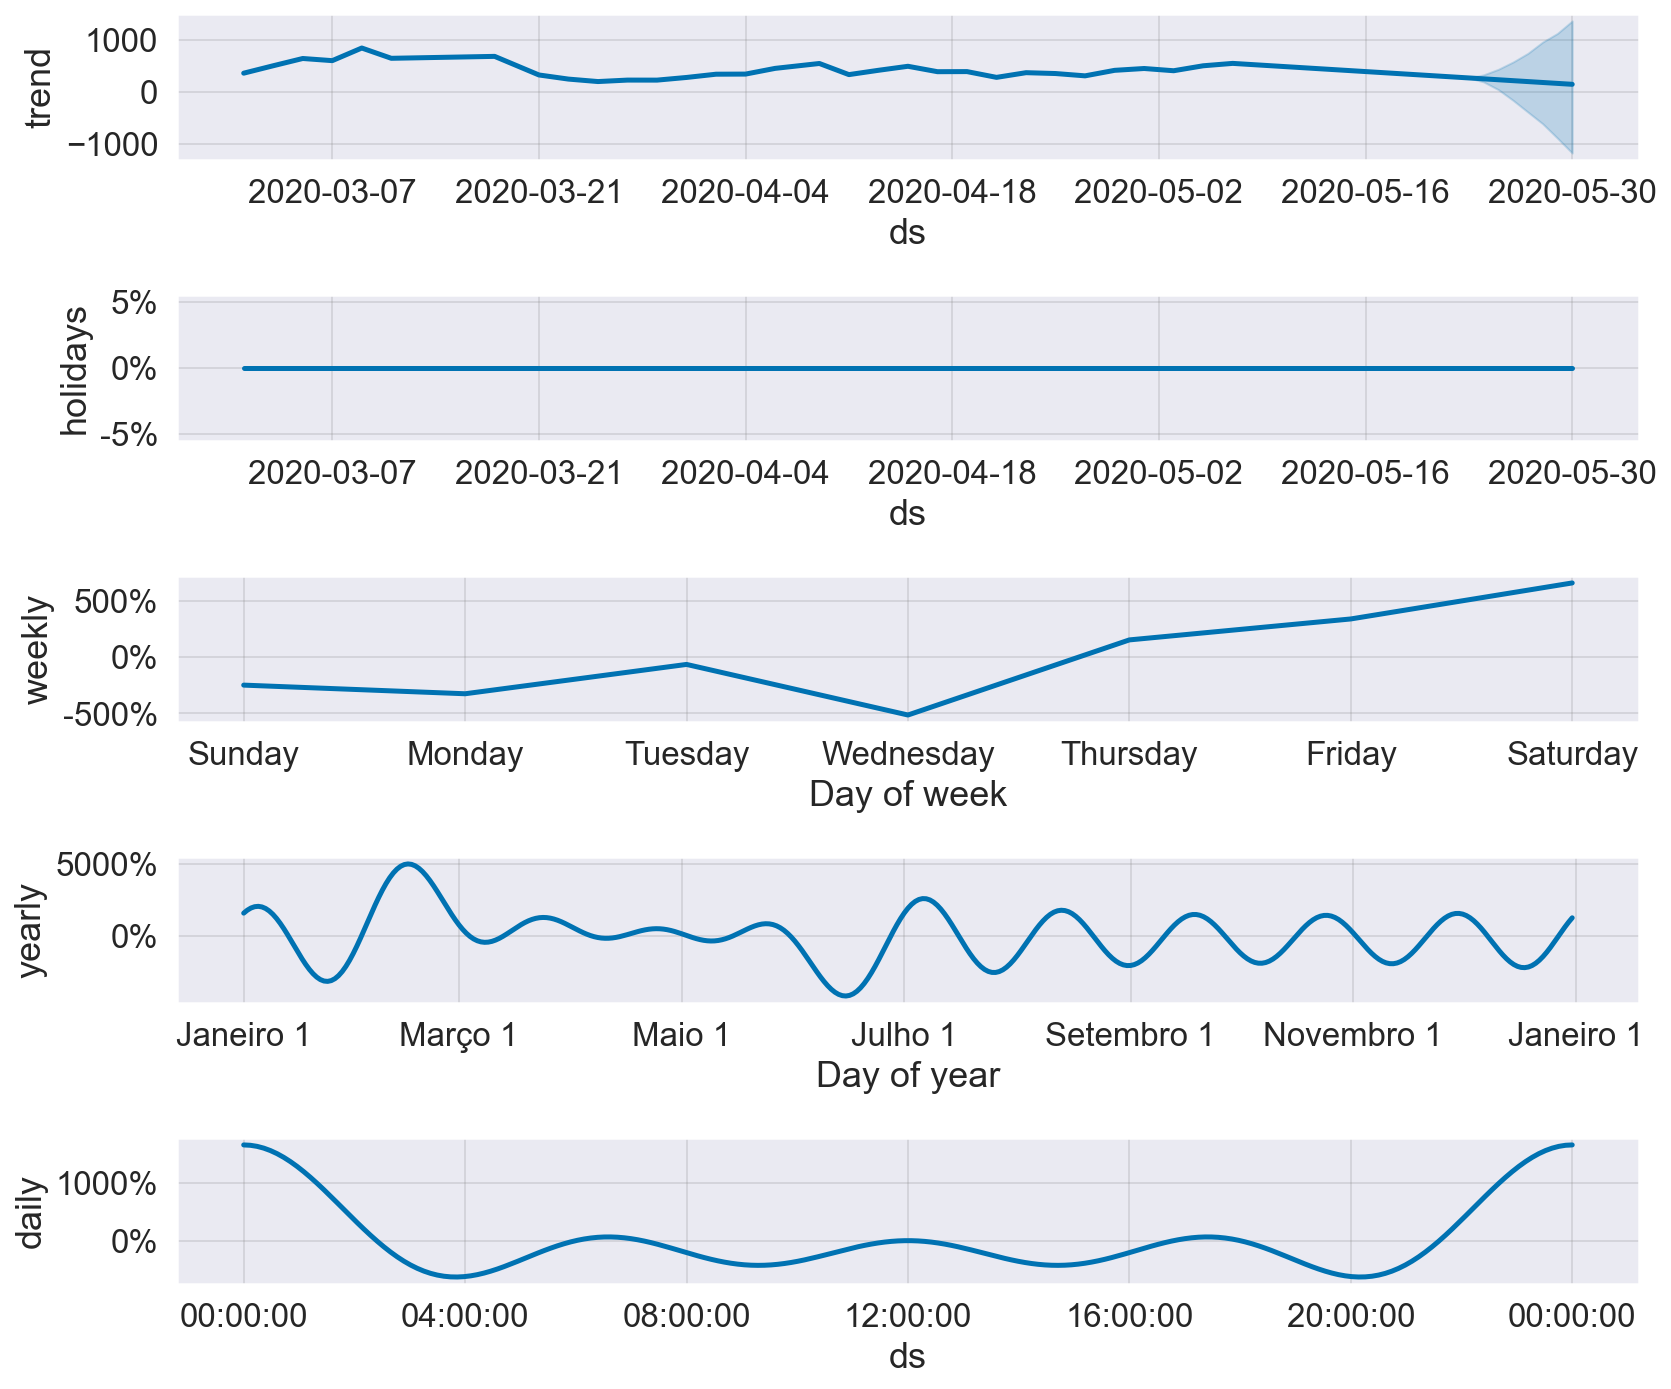

In [62]:
# Plot the components of the model
fig = final_prophet_s_outliers.plot_components(forecast_final_s_outliers, figsize=(12,10))

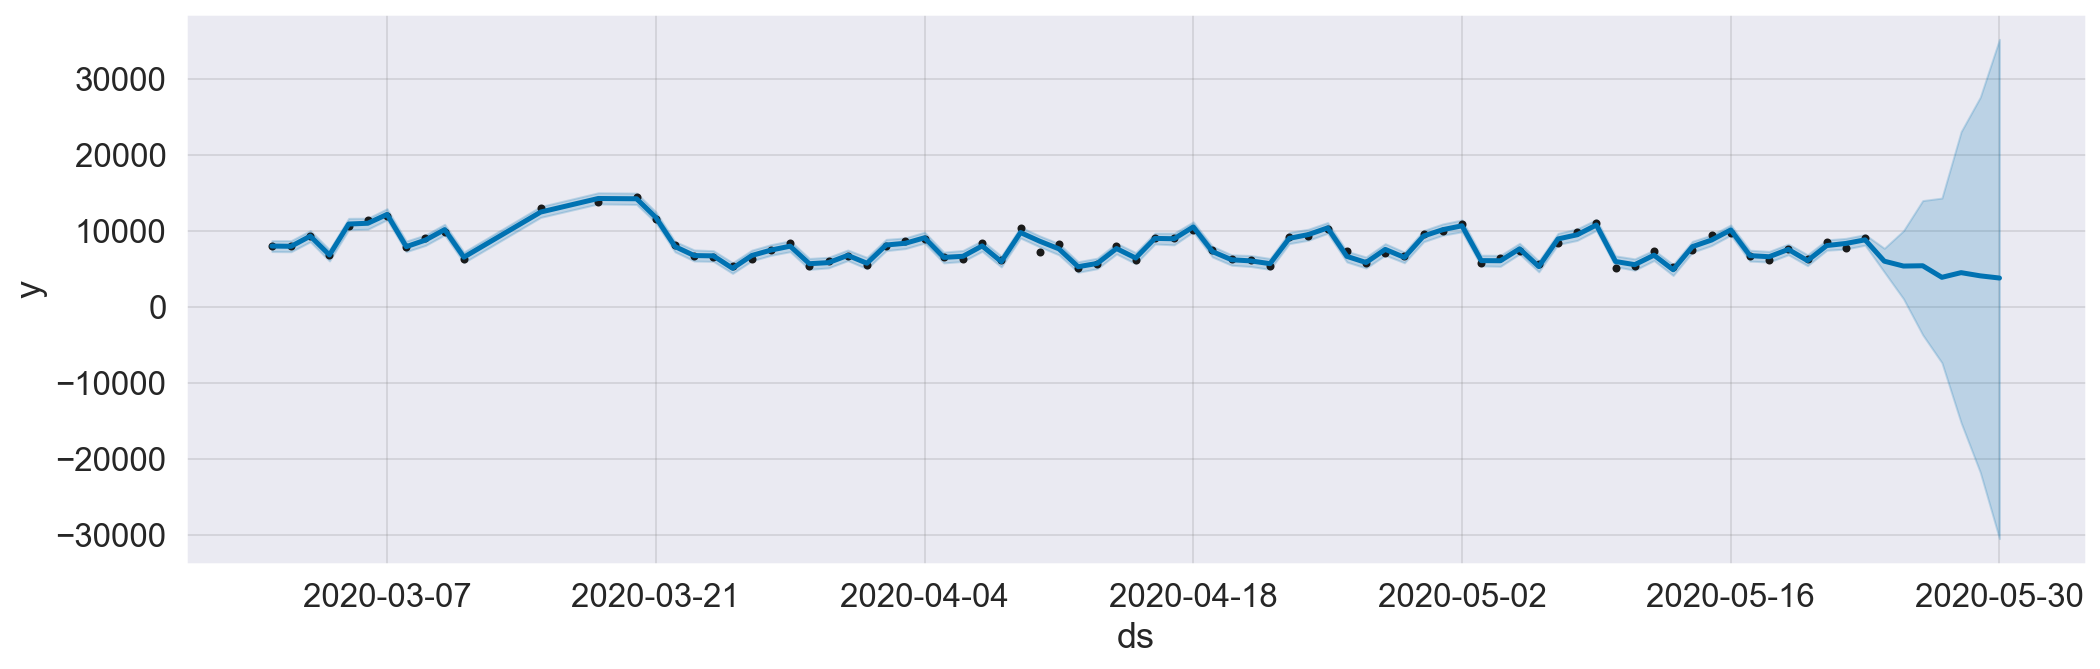

In [63]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet_s_outliers.plot(forecast_final_s_outliers,ax=ax)
plt.show()

In [64]:
# Visualizando a tabela prevista

df_teste_final_s_outliers= final_prophet_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(df_teste_final_s_outliers))

In [65]:
# Comparando os dataframes em gráfico scatter

iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_teste_final_s_outliers,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [66]:
# Comparando os dataframes em gráfico de barras

iplot(dtview.compare_dataframes_with_bar(
    df_274_sem_outliers_teste,
    df_teste_final_s_outliers,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [67]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste.y),
                     np.array(df_teste_final_s_outliers.yhat)))
metrics={'mse':'Mean Square Error', 'mae':'Mean Absolute Error', 'rmse':'Root-Mean Square Error'}
metricas.append(
    fm.evaluate(
        np.array(
            df_274_sem_outliers_teste.y),
        np.array(
            df_teste_final_s_outliers.yhat),metrics=('mse','mae','rmse'))
    )
print("MAPE -----> {}".format(mape_analysis[5]))

MAPE -----> 0.3451345117197922


In [68]:
metricas_keys = mape_keys = ['inicial','feriados','parametros','outliers','outliers feriados','outliers params']
mape_vendas_diarias = dict(zip(mape_keys,mape_analysis))
metricas_vendas_diarias = dict(zip(metricas_keys,metricas))
iplot(dtview.plot_results(
    list(mape_vendas_diarias.keys()),
    list(mape_vendas_diarias.values()),
    title='Evolução da métrica MAPE'))

In [69]:
df_metricas = pd.DataFrame.from_dict(metricas_vendas_diarias)
df_metricas

inicial      feriados    parametros       outliers  \
mse   1.456771e+06  1.456771e+06  1.119625e+07  854468.539421   
mae   1.128809e+03  1.128809e+03  2.646082e+03     704.447107   
rmse  1.206968e+03  1.206968e+03  3.346079e+03     924.374675   

      outliers feriados  outliers params  
mse       854468.539421     1.164517e+07  
mae          704.447107     2.662599e+03  
rmse         924.374675     3.412502e+03

___

In [70]:
df_274_outliers_treino, df_274_outliers_teste = dtexp.configura_dataframe_treino_teste(
    df_274_sale,
    inicio='2020-03-29 08:00:00',
    fim='2020-05-09 21:00:00')
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_outliers_treino.shape))
print('Shape dataframe de teste --> {}'.format(df_274_outliers_teste.shape))
print('-'*60)

------------------------------------------------------------
Shape dataframe de treino --> (41, 2)
Shape dataframe de teste --> (14, 2)
------------------------------------------------------------


In [71]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
prophet_new_outliers = Prophet()
prophet_new_outliers.fit(df_274_outliers_treino)
future_new_outliers = prophet_new_outliers.make_future_dataframe(periods=7, freq='D')
forecast_new_outliers = prophet_new_outliers.predict(future_new_outliers)

iplot(dtview.plot_forecast_as_table(forecast_new_outliers))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


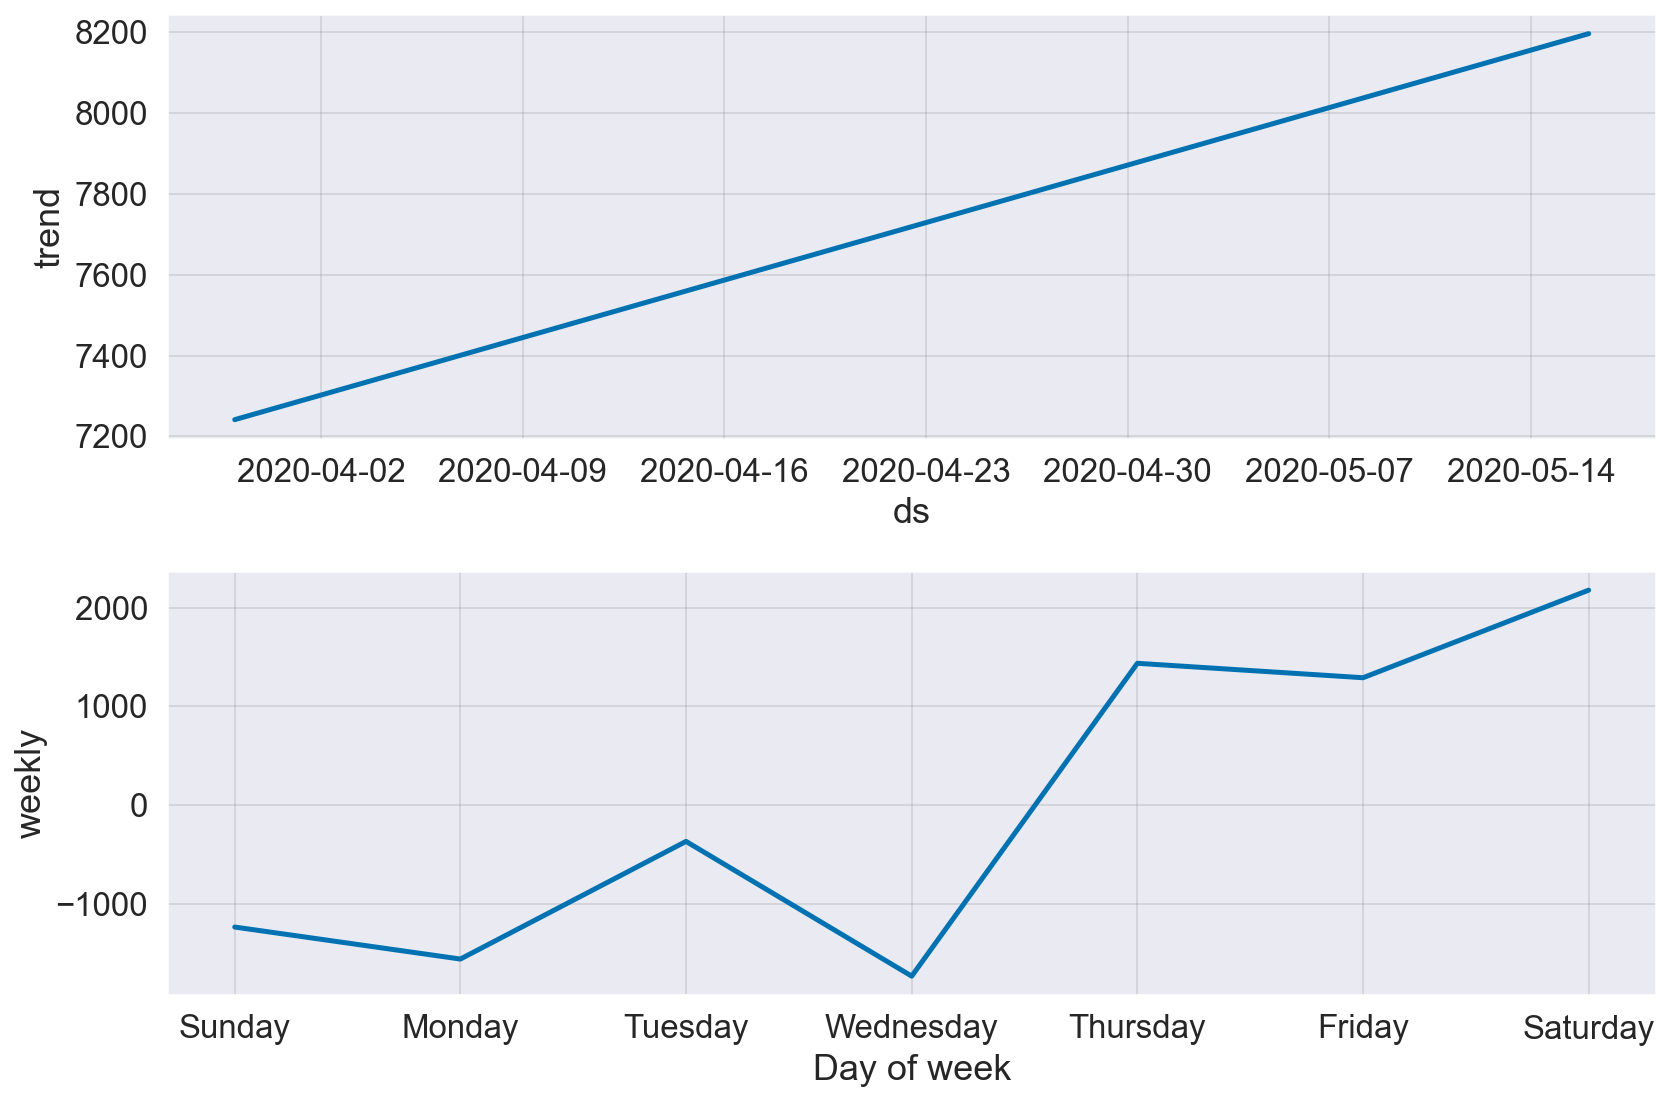

In [72]:
# componentes

fig = prophet_new_outliers.plot_components(forecast_new_outliers, figsize=(12,8))


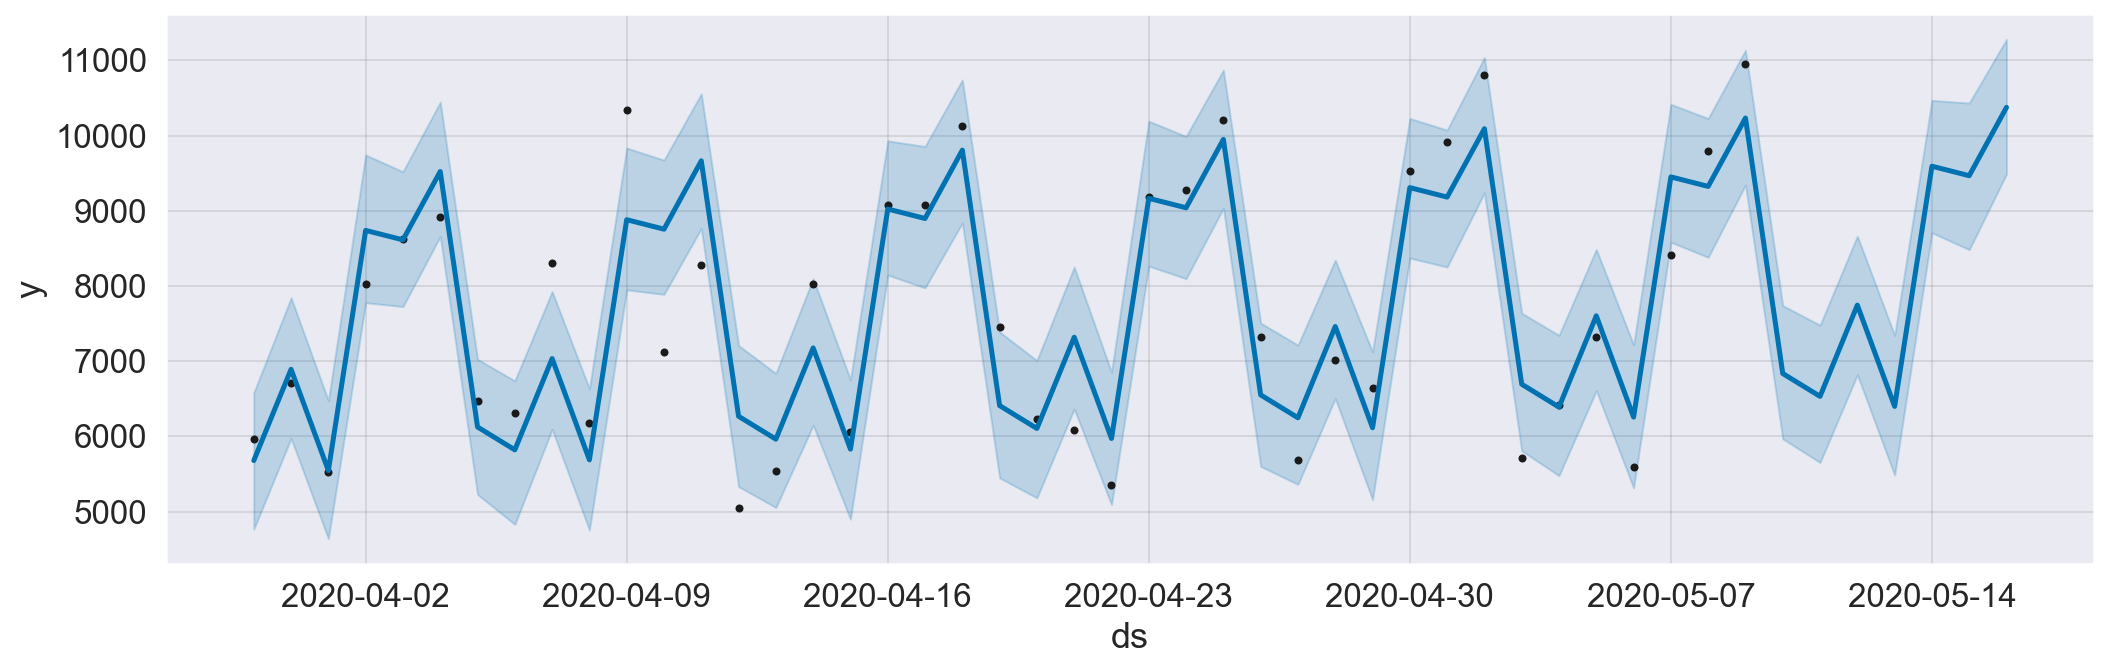

In [73]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_new_outliers.plot(forecast_new_outliers,ax=ax)
plt.show()

In [74]:
df_274_new_outliers_teste_forecast = prophet_new_outliers.predict(df_274_outliers_teste)

In [75]:
iplot(dtview.compare_dataframes_with_scatter(df_274_outliers_teste,
                                   df_274_new_outliers_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

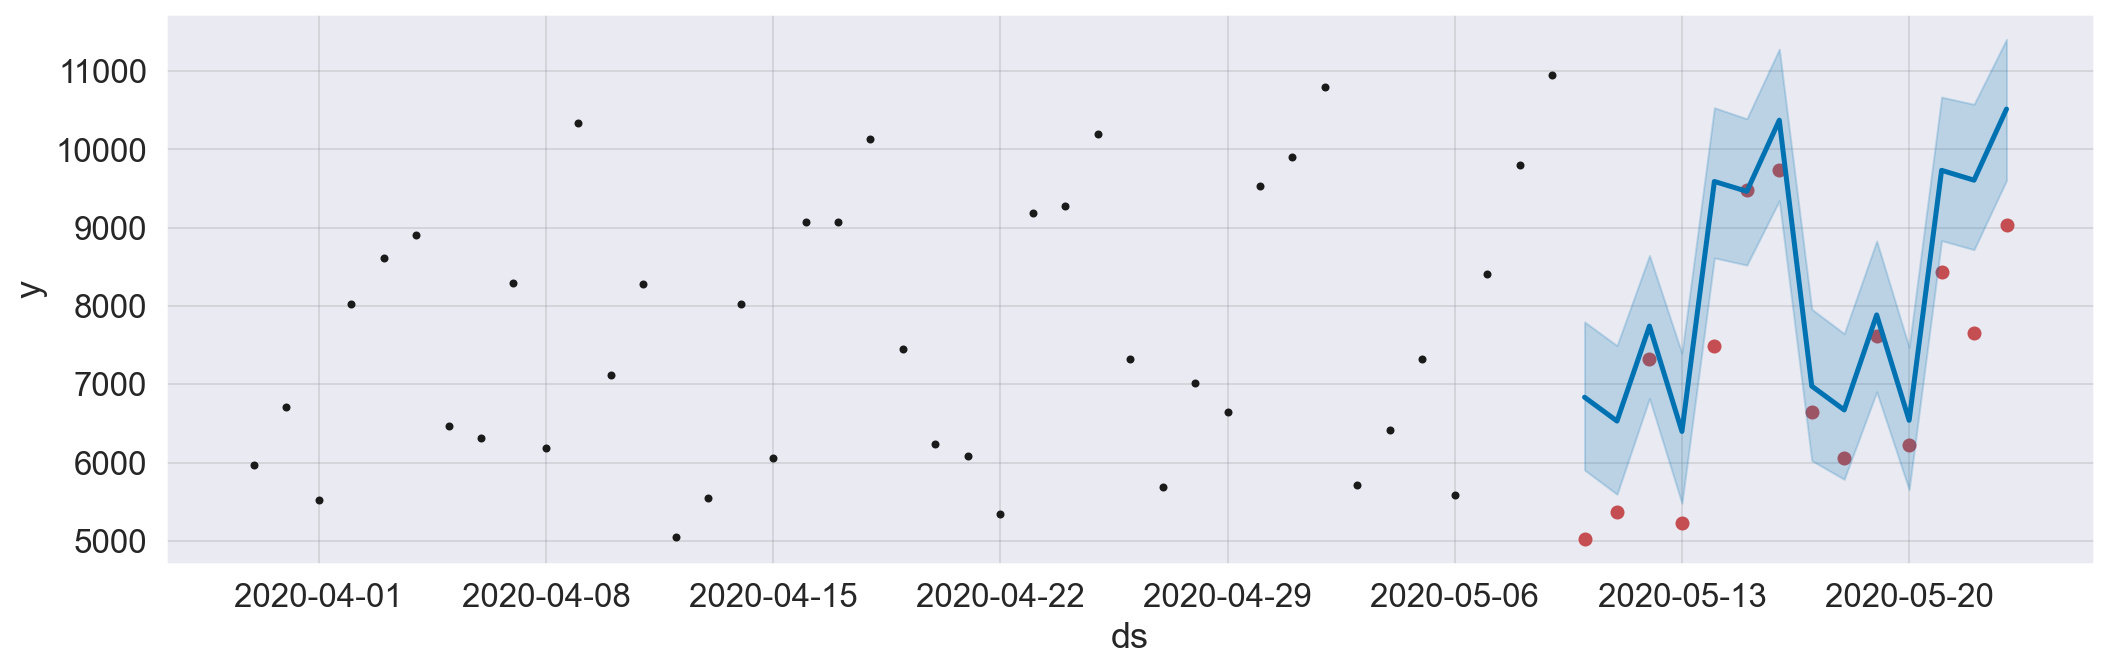

In [76]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_outliers_teste.ds,df_274_outliers_teste['y'], color='r')
fig = prophet_new_outliers.plot(df_274_new_outliers_teste_forecast,ax=ax)
plt.show()

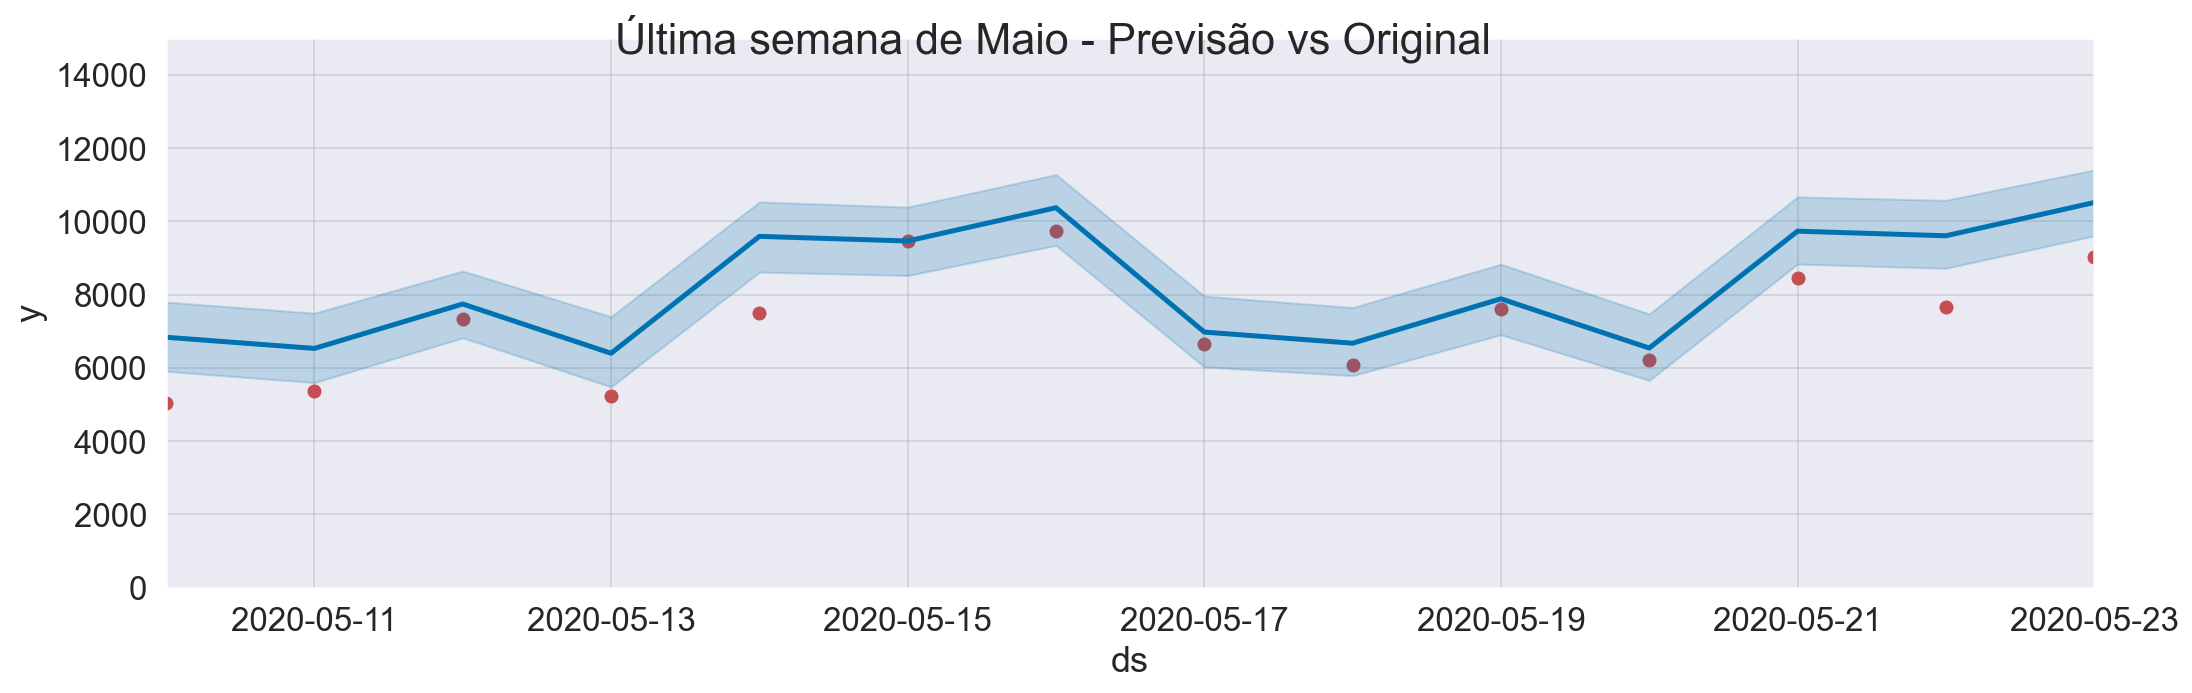

In [77]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_outliers_teste.ds, df_274_outliers_teste['y'], color='r')
fig = prophet_new_outliers.plot(df_274_new_outliers_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-10', upper='2020-05-23')
ax.set_ylim(0, 15000)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

In [78]:
mape_analysis.append(fm.mape(np.array(df_274_outliers_teste.y),
                               np.array(df_274_new_outliers_teste_forecast.yhat)))
metricas.append(
    fm.evaluate(
        np.array(
            df_274_outliers_teste.y),
        np.array(
            df_274_new_outliers_teste_forecast.yhat),metrics=('mse','mae','rmse')
    ))

print("MAPE -----> {}".format(mape_analysis[6]))

MAPE -----> 0.14354137288078217


In [79]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_outliers_teste,
        df_274_new_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

In [80]:
mape_vendas_diarias_n = dict(zip(mape_keys,mape_analysis))
metricas_vendas_diarias_n = dict(zip(metricas_keys,metricas))
iplot(dtview.plot_results(
    list(mape_vendas_diarias_n.keys()),
    list(mape_vendas_diarias_n.values()),
    title='Evolução da métrica MAPE'))

In [81]:
df_metricas = pd.DataFrame.from_dict(metricas_vendas_diarias_n)
metricas_vendas_diarias_n

{'inicial': {'mse': 1456771.1697423684,
  'mae': 1128.8085197079176,
  'rmse': 1206.967758369033},
 'feriados': {'mse': 1456771.1697422592,
  'mae': 1128.808519707876,
  'rmse': 1206.9677583689877},
 'parametros': {'mse': 11196247.22777722,
  'mae': 2646.0818487164256,
  'rmse': 3346.079381571397},
 'outliers': {'mse': 854468.5394209668,
  'mae': 704.4471073847454,
  'rmse': 924.3746748050635},
 'outliers feriados': {'mse': 854468.53942096,
  'mae': 704.447107384741,
  'rmse': 924.3746748050597},
 'outliers params': {'mse': 11645173.180871982,
  'mae': 2662.599251786545,
  'rmse': 3412.5024807129416}}

In [82]:
df_new

mes  diames semana      diasemana num  hora  minuto      y
0   Março       1     09        Domingo   0     0       0   7942
1   Março       2     09  Segunda Feira   1     0       0   7974
2   Março       3     09    Terça Feira   2     0       0   9237
3   Março       4     09   Quarta Feira   3     0       0   6825
4   Março       5     09   Quinta Feira   4     0       0  10643
..    ...     ...    ...            ...  ..   ...     ...    ...
87   Maio      27     21   Quarta Feira   3     0       0   3523
88   Maio      28     21   Quinta Feira   4     0       0   8526
89   Maio      29     21    Sexta Feira   5     0       0   8274
90   Maio      30     21         Sábado   6     0       0  10118
91   Maio      31     22        Domingo   0     0       0   5704

[92 rows x 8 columns]

In [83]:
mascara = (df_new['semana']>'20')
df_teste = df_new.loc[mascara]
df_teste

mes  diames semana      diasemana num  hora  minuto      y
84  Maio      24     21        Domingo   0     0       0   6093
85  Maio      25     21  Segunda Feira   1     0       0   6124
86  Maio      26     21    Terça Feira   2     0       0   6866
87  Maio      27     21   Quarta Feira   3     0       0   3523
88  Maio      28     21   Quinta Feira   4     0       0   8526
89  Maio      29     21    Sexta Feira   5     0       0   8274
90  Maio      30     21         Sábado   6     0       0  10118
91  Maio      31     22        Domingo   0     0       0   5704